In [82]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from operator import add
import os
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.ticker import FixedLocator
from scipy.signal import savgol_filter


sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.8, rc=paper_rc)
current_palette = sns.color_palette()
cmp = sns.color_palette("tab10")

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 4),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=14,
        )
    
def autolabel_h(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(
            "%.2f" % width,
            xy=(width, rect.get_y() + rect.get_height() / 2),
            xytext=(18, -1),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="center",
            size=13,
        )

SAVEPATH = './fig'
os.makedirs(SAVEPATH, exist_ok=True)

# Distributed Comparison

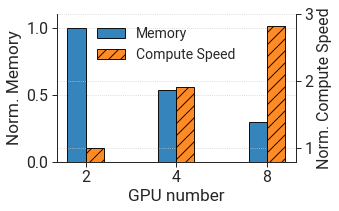

In [103]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4.6, 2.8))

x = np.arange(1, 4)
memory_list = [9069.88, 4861.77, 2663.29]
memory_norm = [ele / memory_list[0] for ele in memory_list]
t_compute = [0.1513, 0.0793, 0.0535]
speed_compute_norm = [t_compute[0]/ele for ele in t_compute]

width = 0.2
p1 = ax.bar(x-width/2, memory_norm, width=width, label='Memory', alpha=0.9, linewidth=1, edgecolor="k", color = [cmp[0]])

ax.set_ylabel(f"Norm. Memory")
ax.set_xticks(x)
ax.set_xlabel(f"GPU number")
ax.set_xticklabels([2,4,8])
ax.set_ylim(0, 1.1)
ax.grid(axis="y", linestyle=":")

ax1 = ax.twinx()
p2 = ax1.bar(x+width/2, speed_compute_norm, width=width, label='Compute Speed', linewidth=1, hatch="//", edgecolor="k", alpha=0.9, color=cmp[1])

ax1.set_ylabel(f"Norm. Compute Speed", fontsize=16)
ax1.set_ylim([0.8, 3])
ax1.grid(axis="y", linestyle=":")

sns.despine(top=True,right=False, left=False, bottom=False)


# lns = p1 + p2
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=4, fontsize=10)
# plt.legend(handles = [p1,p2], loc='best', fontsize=10)
legend = ax.legend(
    loc=1,
    handles=[p1, p2],
    bbox_to_anchor=(0.8, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/distributed.pdf", bbox_inches="tight")

# Profile epoch time breakdown


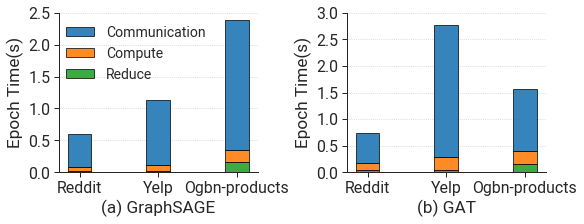

In [71]:
cmp = sns.color_palette("tab10")
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(8, 3))

labels = ['Reddit', 'Yelp', 'Ogbn-products']
reddit_n4 = pd.read_csv(f"./results/reddit_n4_pcie3.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/yelp_n4_pcie3.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/ogbn-products_n4_pcie3.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]

fp32_reddit = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_yelp = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
fp32_products = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
commu = [fp32_reddit['commu'].values[0], fp32_yelp['commu'].values[0], fp32_products['commu'].values[0]] 
compute = [fp32_reddit['compute'].values[0], fp32_yelp['compute'].values[0], fp32_products['compute'].values[0]] 
reduce = [fp32_reddit['reduce'].values[0], fp32_yelp['reduce'].values[0], fp32_products['reduce'].values[0]] 

width = 0.3
y_ticks = np.arange(0, 3.5, 0.5)

A = ax.bar(labels, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
B = ax.bar(labels, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
C = ax.bar(labels, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])

ax.set_ylabel('Epoch Time(s)')
ax.set_ylim(0, 2.5)
# ax.set_title('GraphSAGE')
ax.grid(axis="y", linestyle=":")
ax.set_xlabel('(a) GraphSAGE')

legend = ax.legend(
    loc=1,
    handles=[C, B, A],
    bbox_to_anchor=(0.8, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
sns.despine()

commu = [fp32_reddit['commu'].values[2], fp32_yelp['commu'].values[2], fp32_products['commu'].values[2]] 
compute = [fp32_reddit['compute'].values[2], fp32_yelp['compute'].values[2], fp32_products['compute'].values[2]] 
reduce = [fp32_reddit['reduce'].values[2], fp32_yelp['reduce'].values[2], fp32_products['reduce'].values[2]] 

width = 0.3

A = ax2.bar(labels, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
B = ax2.bar(labels, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
C = ax2.bar(labels, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])

ax2.set_ylabel('Epoch Time(s)')
ax2.set_ylim(0, 3)
ax2.set_yticks(y_ticks)
# ax2.set_title('GAT')
ax2.grid(axis="y", linestyle=":")
ax2.set_xlabel('(b) GAT')

# legend = ax2.legend(
#     loc=1,
#     handles=[C, B, A],
#     bbox_to_anchor=(0.8, 1),
#     ncol=1,
#     frameon=False,
#     fancybox=True,
#     shadow=True,
#     fontsize=14,
# )
sns.despine()

save=False
if save:
    fig.savefig(f"{SAVEPATH}/tbreakdown.pdf", bbox_inches="tight")



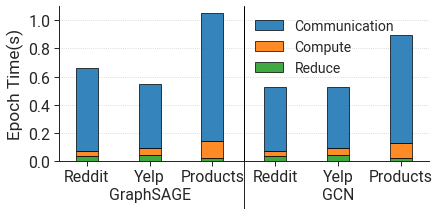

In [17]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 2.8))

labels = ['Reddit', 'Yelp', 'Ogbn-products']
reddit_n4 = pd.read_csv(f"./results/speed_pcie4_oregon/reddit_n8.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/speed_pcie4_oregon/yelp_n8.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/speed_pcie4_oregon/ogbn-products_n8.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]

fp32_reddit = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_yelp = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
fp32_products = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
commu = [fp32_reddit['commu'].values[0], fp32_yelp['commu'].values[0], fp32_products['commu'].values[0]] 
compute = [fp32_reddit['compute'].values[0], fp32_yelp['compute'].values[0], fp32_products['compute'].values[0]] 
reduce = [fp32_reddit['reduce'].values[0], fp32_yelp['reduce'].values[0], fp32_products['reduce'].values[0]] 

width = 0.35
y_ticks = np.arange(0, 1.2, 0.2)

x1 = np.arange(0, 3)
A = ax.bar(x1, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
B = ax.bar(x1, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
C = ax.bar(x1, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])

commu = [fp32_reddit['commu'].values[1], fp32_yelp['commu'].values[1], fp32_products['commu'].values[1]] 
compute = [fp32_reddit['compute'].values[1], fp32_yelp['compute'].values[1], fp32_products['compute'].values[1]] 
reduce = [fp32_reddit['reduce'].values[1], fp32_yelp['reduce'].values[1], fp32_products['reduce'].values[1]] 

x2 = np.arange(3, 6)
ax.bar(x2, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
ax.bar(x2, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
ax.bar(x2, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])

ax.axvline(x=2.5, ls='-', c='k', lw=1)
ax.xaxis.set_minor_locator(FixedLocator([2.5]))
ax.xaxis.set_label_coords(.5, -.2)
ax.tick_params('x', length=50, width=1
, which='minor')

ax.set_ylabel('Epoch Time(s)')
ax.set_ylim(0, 1.1)
ax.set_yticks(y_ticks)
ax.grid(axis="y", linestyle=":")
# ax.set_xlabel('(b) GAT')
ax.set_xticks(range(0,6))
ax.set_xticklabels(['Reddit', 'Yelp\nGraphSAGE', 'Products', 'Reddit', 'Yelp\nGCN', 'Products'])

legend = ax.legend(
    loc=1,
    handles=[C, B, A],
    bbox_to_anchor=(0.94, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
sns.despine()

save=True
if save:
    fig.savefig(f"{SAVEPATH}/tbreakdown.pdf", bbox_inches="tight")


In [6]:
fp32_reddit

,dataset,model,epoch,datatype,pipeline,fixed synchro,rank,epoch time,commu,reduce,compute,accuracy,peak memory
0,reddit,"['graphsage', 4, 256]",100,fp32,False,NaN,0,0.663600,0.592128,0.035188,0.036284,0.941798,961.196777
4,reddit,"['gcn', 4, 256]",100,fp32,False,NaN,0,0.528183,0.456800,0.036889,0.034494,0.936826,756.474121
8,reddit,"['gat', 2, 256]",100,fp32,False,NaN,0,0.211500,0.151166,0.040178,0.020156,0.933756,525.909180


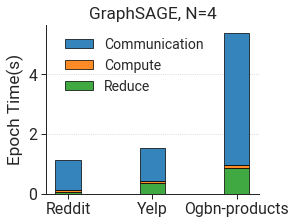

In [63]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4, 3))
labels = ['Reddit', 'Yelp', 'Ogbn-products']

reddit_n4 = pd.read_csv(f"./results/reddit_n7_pcie3.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/yelp_n7_pcie3.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
amazon_n7 = pd.read_csv(f'./results/amazon_n7_pcie3.csv', index_col=False)
amazon_n7 = amazon_n7.loc[:, ~amazon_n7.columns.str.contains('^Unnamed')]

fp32_reddit = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_yelp = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
fp32_products = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
fp32_amazon = amazon_n7[(amazon_n7['datatype'] == 'fp32') & (amazon_n7['pipeline'] == False)]

commu = [fp32_reddit['commu'].values[0], fp32_yelp['commu'].values[0], fp32_amazon['commu'].values[2]] 
compute = [fp32_reddit['compute'].values[0], fp32_yelp['compute'].values[0], fp32_amazon['compute'].values[2]] 
reduce = [fp32_reddit['reduce'].values[0], fp32_yelp['reduce'].values[0], fp32_amazon['reduce'].values[2]] 

width = 0.3

A = ax.bar(labels, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
B = ax.bar(labels, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
C = ax.bar(labels, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])

ax.set_ylabel('Epoch Time(s)')
# ax.set_ylim(0, 2.5)
ax.set_title('GraphSAGE, N=4')
ax.grid(axis="y", linestyle=":")

legend = ax.legend(
    loc=1,
    handles=[C, B, A],
    bbox_to_anchor=(0.8, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
sns.despine()



# Distributed advantange + Profile breakdown

/tmp/ipykernel_2364017/342740384.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0.5, hspace =0)


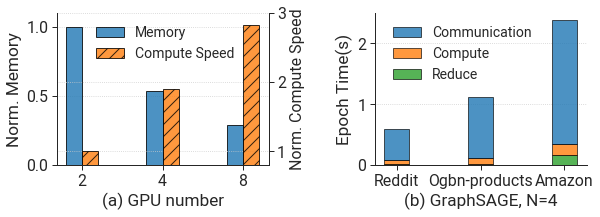

In [45]:
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1, 1])
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(9.5, 2.8))
fig.subplots_adjust(wspace=0.5, hspace =0)

x = np.arange(1, 4)
memory_list = [9069.88, 4861.77, 2663.29]
memory_norm = [ele / memory_list[0] for ele in memory_list]
t_compute = [0.1513, 0.0793, 0.0535]
speed_compute_norm = [t_compute[0]/ele for ele in t_compute]

width = 0.2
p1 = ax.bar(x-width/2, memory_norm, width=width, label='Memory', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[0]])

ax.set_ylabel(f"Norm. Memory")
ax.set_xticks(x)
ax.set_xlabel(f"(a) GPU number")
ax.set_xticklabels([2,4,8])
ax.set_ylim(0, 1.1)
ax.grid(axis="y", linestyle=":")

ax1 = ax.twinx()
p2 = ax1.bar(x+width/2, speed_compute_norm, width=width, label='Compute Speed', linewidth=1, hatch="//", edgecolor="k", alpha=0.8, color=cmp[1])

ax1.set_ylabel(f"Norm. Compute Speed", fontsize=16)
ax1.set_ylim([0.8, 3])
ax1.grid(axis="y", linestyle=":")

ax.spines['top'].set_visible(False)
ax1.spines['top'].set_visible(False)

# lns = p1 + p2
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=4, fontsize=10)
# plt.legend(handles = [p1,p2], loc='best', fontsize=10)
legend = ax.legend(
    loc=1,
    handles=[p1, p2],
    bbox_to_anchor=(0.9, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)

labels = ['Reddit', 'Ogbn-products', 'Amazon']

reddit_n4 = pd.read_csv(f"./results/reddit_n4_pcie3.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/yelp_n4_pcie3.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/ogbn-products_n4_pcie3.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]

fp32_reddit = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_yelp = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
fp32_products = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
commu = [fp32_reddit['commu'].values[0], fp32_yelp['commu'].values[0], fp32_products['commu'].values[0]] 
compute = [fp32_reddit['compute'].values[0], fp32_yelp['compute'].values[0], fp32_products['compute'].values[0]] 
reduce = [fp32_reddit['reduce'].values[0], fp32_yelp['reduce'].values[0], fp32_products['reduce'].values[0]] 

width = 0.3

A = ax2.bar(labels, reduce, width, edgecolor="k", label='Reduce', alpha=0.8, color = [cmp[2]])
B = ax2.bar(labels, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.8, color = [cmp[1]])
C = ax2.bar(labels, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.8, color = [cmp[0]])

ax2.set_ylabel('Epoch Time(s)')
ax2.set_ylim(0, 2.5)
# ax2.set_title('Graphsage, N=4')
ax2.set_xlabel('(b) GraphSAGE, N=4')
ax2.grid(axis="y", linestyle=":")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

legend = ax2.legend(
    loc=1,
    handles=[C, B, A],
    bbox_to_anchor=(0.8, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/combine2.pdf", bbox_inches="tight")

# Intro: our result

multi-node

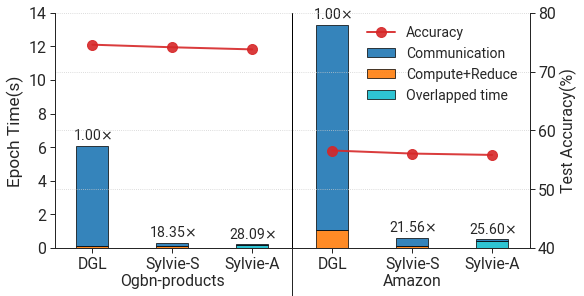

In [16]:
def autolabel(rects, ax, bottom, text):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i in range(len(rects)):
        height = rects[i].get_height() + bottom[i]
        ax.annotate(
            r"%.2f$\times$" % text[i],
            xy=(rects[i].get_x() + rects[i].get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=14,
        )

cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(8, 4))

commu = [5.9314, 0.2181, 0.0309]
others  = [0.1447, 0.1130, 0.1854]
ratio = [1, 18.35, 28.09]

width = 0.4
x1 = np.arange(0, 3)
A = ax.bar(x1, others, width, edgecolor="k", label='Compute+Reduce', alpha=0.9, color = [cmp[1], cmp[1], cmp[-1]])
B = ax.bar(x1, commu, width, bottom=others, edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])
autolabel(B, ax, others, ratio)

commu = [12.1851, 0.5083, 0.1255]
others  = [1.0917, 0.1074, 0.3932]
ratio = [1, 21.56, 25.60]

x2 = np.arange(3, 6)
C = ax.bar(x2, others, width, edgecolor="k", label='Compute+Reduce', alpha=0.9, color = [cmp[1], cmp[1], cmp[-1]])
D = ax.bar(x2, commu, width, bottom=others, edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])
autolabel(D, ax, others, ratio)

ax.axvline(x=2.5, ls='-', c='k', lw=1)
ax.xaxis.set_minor_locator(FixedLocator([2.5]))
ax.xaxis.set_label_coords(.5, -.2)
ax.tick_params('x', length=50, width=1
, which='minor')

ax.set_ylabel('Epoch Time(s)')
ax.set_ylim(0, 14)
# y_ticks = np.arange(0, 15, 2)
# ax.set_yticks(y_ticks)
# ax.grid(axis="y", linestyle=":")
# ax.set_xlabel('(b) GAT')
ax.set_xticks(range(0,6))
ax.set_xticklabels(['DGL', 'Sylvie-S\nOgbn-products', 'Sylvie-A', 'DGL', 'Sylvie-S\nAmazon', 'Sylvie-A'])

ax1 = ax.twinx()
acc1 = [74.58, 74.14, 73.78]
acc2 = [56.59, 56.07, 55.84]
acc1_err = [0.09, 0.72, 0.39]
acc2_err = [0.11, 0.07, 0.21]

E, = ax1.plot(x1, acc1, label='Accuracy', linewidth=2, marker="o", alpha=0.9, color=cmp[3])
F, = ax1.plot(x2, acc2, label='Accuracy', linewidth=2, marker="o", alpha=0.9, color=cmp[3])

# for i in range(len(acc1)):
#     ax1.text(x1[i], acc1[i]+1, '%.2f' %round(acc1[i],3), ha='center', fontsize=14)
# for i in range(1, len(acc2)):
#     ax1.text(x2[i], acc2[i]+1, '%.2f' %round(acc2[i],3), ha='center', fontsize=14)
# ax1.text(x2[0]+0.45, acc2[0]-2, '%.2f' %round(acc2[0],3), ha='center', fontsize=14)

ax1.set_ylabel(f"Test Accuracy(%)", fontsize=16)
ax1.set_ylim(40, 80)
# ax1.set_yticks(np.arange(70, 105, 5))
ax1.grid(axis="y", linestyle=":")

sns.despine(top=True,right=False, left=False, bottom=False)

C = mpatches.Patch(facecolor=cmp[-1], alpha=0.9, edgecolor="black", label="Overlapped time")
# Combine plot labels
lns = [E,B,A,C]
labs = [l.get_label() for l in lns]
ax1.legend(
    lns, 
    labs, 
    # bbox_to_anchor=(, 1.1),
    loc=0, 
    ncol=1, 
    frameon=False,
    fontsize=14
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/first.pdf", bbox_inches="tight")


single-node, N=8

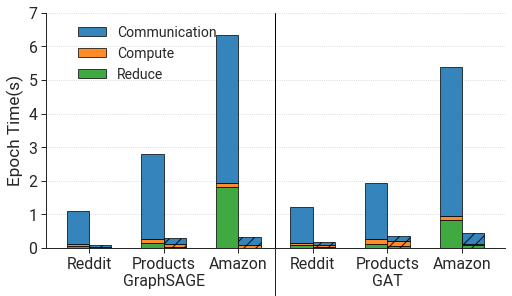

In [36]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(7, 4))

labels = ['Reddit', 'Ogbn-products', 'Amazon']
reddit_n4 = pd.read_csv(f"./results/reddit_n7_pcie3.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/ogbn-products_n7_pcie3.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/amazon_n7_pcie3.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

fp32_reddit = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_products = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
fp32_amazon = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
commu = [fp32_reddit['commu'].values[0], fp32_products['commu'].values[0], fp32_amazon['commu'].values[0]] 
compute = [fp32_reddit['compute'].values[0], fp32_products['compute'].values[0], fp32_amazon['compute'].values[0]] 
reduce = [fp32_reddit['reduce'].values[0], fp32_products['reduce'].values[0], fp32_amazon['reduce'].values[0]] 

bg_reddit = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == False)]
bg_products = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
bg_amazon = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == False)]
bg_commu = [bg_reddit['commu'].values[0], bg_products['commu'].values[0], bg_amazon['commu'].values[0]] 
bg_compute = [bg_reddit['compute'].values[0], bg_products['compute'].values[0], bg_amazon['compute'].values[0]] 
bg_reduce = [bg_reddit['reduce'].values[0], bg_products['reduce'].values[0], bg_amazon['reduce'].values[0]] 

width = 0.3
x1 = np.arange(0, 3)
A = ax.bar(x1-width/2, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
B = ax.bar(x1-width/2, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
C = ax.bar(x1-width/2, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])
ax.bar(x1+width/2, bg_reduce, width, edgecolor="k", label='Reduce', hatch='//', alpha=0.9, color = [cmp[2]])
ax.bar(x1+width/2, bg_compute, width, bottom=bg_reduce, edgecolor="k", label='Compute', hatch='//', alpha=0.9, color = [cmp[1]])
ax.bar(x1+width/2, bg_commu, width, bottom=list(map(add, bg_reduce, bg_compute)), edgecolor="k", label='Communication', hatch='//', alpha=0.9, color = [cmp[0]])

commu = [fp32_reddit['commu'].values[2], fp32_products['commu'].values[2], fp32_amazon['commu'].values[2]] 
compute = [fp32_reddit['compute'].values[2], fp32_products['compute'].values[2], fp32_amazon['compute'].values[2]] 
reduce = [fp32_reddit['reduce'].values[2], fp32_products['reduce'].values[2], fp32_amazon['reduce'].values[2]] 

bg_commu = [bg_reddit['commu'].values[2], bg_products['commu'].values[2], bg_amazon['commu'].values[2]] 
bg_compute = [bg_reddit['compute'].values[2], bg_products['compute'].values[2], bg_amazon['compute'].values[2]] 
bg_reduce = [bg_reddit['reduce'].values[2], bg_products['reduce'].values[2], bg_amazon['reduce'].values[2]] 

x2 = np.arange(3, 6)
ax.bar(x2-width/2, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
ax.bar(x2-width/2, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
ax.bar(x2-width/2, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])
ax.bar(x2+width/2, bg_reduce, width, edgecolor="k", label='Reduce', hatch='//', alpha=0.9, color = [cmp[2]])
ax.bar(x2+width/2, bg_compute, width, bottom=bg_reduce, edgecolor="k", label='Compute', hatch='//', alpha=0.9, color = [cmp[1]])
ax.bar(x2+width/2, bg_commu, width, bottom=list(map(add, bg_reduce, bg_compute)), edgecolor="k", label='Communication', hatch='//', alpha=0.9, color = [cmp[0]])

ax.axvline(x=2.5, ls='-', c='k', lw=1)
ax.xaxis.set_minor_locator(FixedLocator([2.5]))
ax.xaxis.set_label_coords(.5, -.2)
ax.tick_params('x', length=50, width=1
, which='minor')

ax.set_ylabel('Epoch Time(s)')
ax.set_ylim(0, 7)
# y_ticks = np.arange(0, 14, 2)
# ax.set_yticks(y_ticks)
ax.grid(axis="y", linestyle=":")
# ax.set_xlabel('(b) GAT')
ax.set_xticks(range(0,6))
ax.set_xticklabels(['Reddit', 'Products\nGraphSAGE', 'Amazon', 'Reddit', 'Products\nGAT', 'Amazon'])

legend = ax.legend(
    loc=1,
    handles=[C, B, A],
    bbox_to_anchor=(0.4, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
sns.despine()

save=False
if save:
    fig.savefig(f"{SAVEPATH}/tbreakdown.pdf", bbox_inches="tight")

In [ ]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(7, 4))

labels = ['Reddit', 'Ogbn-products', 'Amazon']
reddit_n4 = pd.read_csv(f"./results/reddit_n7_pcie3.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/ogbn-products_n7_pcie3.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/amazon_n7_pcie3.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

fp32_reddit = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_products = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
fp32_amazon = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
commu = [fp32_reddit['commu'].values[0], fp32_products['commu'].values[0], fp32_amazon['commu'].values[0]] 
compute = [fp32_reddit['compute'].values[0], fp32_products['compute'].values[0], fp32_amazon['compute'].values[0]] 
reduce = [fp32_reddit['reduce'].values[0], fp32_products['reduce'].values[0], fp32_amazon['reduce'].values[0]] 

bg_reddit = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == False)]
bg_products = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
bg_amazon = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == False)]
bg_commu = [bg_reddit['commu'].values[0], bg_products['commu'].values[0], bg_amazon['commu'].values[0]] 
bg_compute = [bg_reddit['compute'].values[0], bg_products['compute'].values[0], bg_amazon['compute'].values[0]] 
bg_reduce = [bg_reddit['reduce'].values[0], bg_products['reduce'].values[0], bg_amazon['reduce'].values[0]] 

width = 0.3
x1 = np.arange(0, 3)
A = ax.bar(x1-width/2, fp32_reddit['epoch time'].values, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
B = ax.bar(x1-width/2, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
ax.bar(x1+width/2, bg_reduce, width, edgecolor="k", label='Reduce', hatch='//', alpha=0.9, color = [cmp[2]])
ax.bar(x1+width/2, bg_compute, width, bottom=bg_reduce, edgecolor="k", label='Compute', hatch='//', alpha=0.9, color = [cmp[1]])
ax.bar(x1+width/2, bg_commu, width, bottom=list(map(add, bg_reduce, bg_compute)), edgecolor="k", label='Communication', hatch='//', alpha=0.9, color = [cmp[0]])

commu = [fp32_reddit['commu'].values[2], fp32_products['commu'].values[2], fp32_amazon['commu'].values[2]] 
compute = [fp32_reddit['compute'].values[2], fp32_products['compute'].values[2], fp32_amazon['compute'].values[2]] 
reduce = [fp32_reddit['reduce'].values[2], fp32_products['reduce'].values[2], fp32_amazon['reduce'].values[2]] 

bg_commu = [bg_reddit['commu'].values[2], bg_products['commu'].values[2], bg_amazon['commu'].values[2]] 
bg_compute = [bg_reddit['compute'].values[2], bg_products['compute'].values[2], bg_amazon['compute'].values[2]] 
bg_reduce = [bg_reddit['reduce'].values[2], bg_products['reduce'].values[2], bg_amazon['reduce'].values[2]] 

x2 = np.arange(3, 6)
ax.bar(x2-width/2, reduce, width, edgecolor="k", label='Reduce', alpha=0.9, color = [cmp[2]])
ax.bar(x2-width/2, compute, width, bottom=reduce, edgecolor="k", label='Compute', alpha=0.9, color = [cmp[1]])
ax.bar(x2-width/2, commu, width, bottom=list(map(add, reduce, compute)), edgecolor="k", label='Communication', alpha=0.9, color = [cmp[0]])
ax.bar(x2+width/2, bg_reduce, width, edgecolor="k", label='Reduce', hatch='//', alpha=0.9, color = [cmp[2]])
ax.bar(x2+width/2, bg_compute, width, bottom=bg_reduce, edgecolor="k", label='Compute', hatch='//', alpha=0.9, color = [cmp[1]])
ax.bar(x2+width/2, bg_commu, width, bottom=list(map(add, bg_reduce, bg_compute)), edgecolor="k", label='Communication', hatch='//', alpha=0.9, color = [cmp[0]])

ax.axvline(x=2.5, ls='-', c='k', lw=1)
ax.xaxis.set_minor_locator(FixedLocator([2.5]))
ax.xaxis.set_label_coords(.5, -.2)
ax.tick_params('x', length=50, width=1
, which='minor')

ax.set_ylabel('Epoch Time(s)')
ax.set_ylim(0, 7)
# y_ticks = np.arange(0, 14, 2)
# ax.set_yticks(y_ticks)
ax.grid(axis="y", linestyle=":")
# ax.set_xlabel('(b) GAT')
ax.set_xticks(range(0,6))
ax.set_xticklabels(['Reddit', 'Products\nGraphSAGE', 'Amazon', 'Reddit', 'Products\nGAT', 'Amazon'])

legend = ax.legend(
    loc=1,
    handles=[C, B, A],
    bbox_to_anchor=(0.4, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
sns.despine()

save=False
if save:
    fig.savefig(f"{SAVEPATH}/tbreakdown.pdf", bbox_inches="tight")

In [35]:
fp32_amazon

,dataset,model,epoch,datatype,pipeline,rank,epoch time,commu,reduce,compute,accuracy,peak memory
0,amazon,"['graphsage', 4, 512]",2000,fp32,False,0,6.335364,4.410939,1.827412,0.097013,0.812919,5039.355957
6,amazon,"['gcn', 4, 512]",2000,fp32,False,0,2.574385,1.817605,0.680684,0.076096,0.565875,4385.799316
12,amazon,"['gat', 3, 512]",1000,fp32,False,0,5.388475,4.422625,0.848696,0.117153,0.396089,7113.230469


# Throughput Comparison

N=8, pcie4.0, with eval

reddit:
sar: [0.55995817 0.57439236 0.09878743]
pipegcn: [1.15654103 1.13419116 1.58250171]
bnsgcn: [2.99583678 2.82042448 1.65174006]
1bg-S: [3.84687715 3.44770367 1.99012434]
1bg-A: [4.89098758 4.23374078 2.10267545]
yelp:
sar: [0.98833522 1.0351774  0.09663043]
pipegcn: [1.25952214 1.1957772  1.33114324]
bnsgcn: [2.9477636  2.57698445 2.83258634]
1bg: [3.83367211 3.5637367  3.18401953]
1bg-p: [4.48033283 4.2578876  3.521519  ]
ogbn-products:
sar: [1.27494262 1.31511676 0.24562455]
pipegcn: [1.18047267 1.20584048 1.49776516]
bnsgcn: [2.085886   1.75595183 1.6448854 ]
1bg: [2.76041434 2.62621959 1.90538835]
1bg-p: [3.6806354  3.49920799 2.00798905]
amazon:
sar: [1.11581135 1.23181733 0.29910601]
pipegcn: [1.09881942 1.05197527 1.41432528]
bnsgcn: [2.63647282 2.21656113 1.21109963]
1bg: [2.93020765 2.5841964  1.37381466]
1bg-p: [3.32298848 2.83338329 1.41863648]


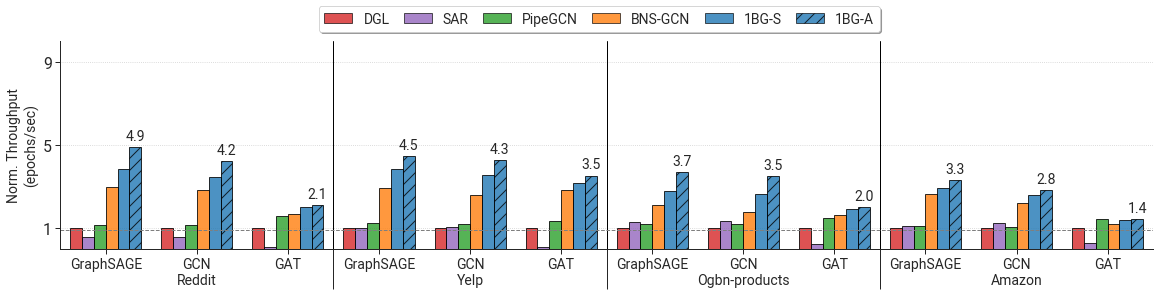

In [8]:

# def trace_analysis(save=False):
cmp = sns.color_palette("tab10")
# grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(16, 4))

# prepocess data
reddit_n4 = pd.read_csv(f"./results/speed_pcie4_oregon/reddit_n4.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/speed_pcie4_oregon/yelp_n4.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/speed_pcie4_oregon/ogbn-products_n4.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/speed_pcie4_oregon/amazon_n4.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

# bns-gcn baseline data
reddit_n4_bns = pd.read_csv(f"./results/speed_pcie4_oregon/bnsgcn/reddit_n4_p0.1_bns.csv", index_col=False)
reddit_n4_bns = reddit_n4_bns.loc[:, ~reddit_n4_bns.columns.str.contains('^Unnamed')]
yelp_n4_bns = pd.read_csv(f'./results/speed_pcie4_oregon/bnsgcn/yelp_n4_p0.1_bns.csv', index_col=False)
yelp_n4_bns = yelp_n4_bns.loc[:, ~yelp_n4_bns.columns.str.contains('^Unnamed')]
products_n4_bns = pd.read_csv(f'./results/speed_pcie4_oregon/bnsgcn/ogbn-products_n4_p0.1_bns.csv', index_col=False)
products_n4_bns = products_n4_bns.loc[:, ~products_n4_bns.columns.str.contains('^Unnamed')]
amazon_bns = pd.read_csv(f'./results/speed_pcie4_oregon/bnsgcn/amazon_n4_p0.1_bns.csv', index_col=False)
amazon_bns = amazon_bns.loc[:, ~amazon_bns.columns.str.contains('^Unnamed')]

# SAR baseline
sar = pd.read_csv(f"./results/speed_pcie4_v2/sar/sar_n4_oregon.csv", index_col=False)
sar = sar.loc[:, ~sar.columns.str.contains('^Unnamed')]
reddit_sar = sar[sar['dataset']=='reddit']
yelp_sar = sar[sar['dataset']=='yelp']
products_sar = sar[sar['dataset']=='ogbn-products']
amazon_sar = sar[sar['dataset']=='amazon']

############################# reddit
fp32_dgl = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
pipegcn = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == True)]
int4my = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == False)]
int4my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == True)]
int1my = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == False)]
int1my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values
print('reddit:')
print(f"sar: {fp32_base/reddit_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/reddit_n4_bns['epoch time'].values}")
print(f"1bg-S: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-A: {fp32_base/int1my_pipe['epoch time'].values}")


x1 = np.arange(1, 4)
width = 0.13

ax1.bar(x1 - width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x1 - width*1.5, fp32_base/reddit_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x1 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x1 + width*0.5, fp32_base/reddit_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x1 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_A=ax1.bar(x1 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/true
autolabel(VALUE_A, ax1)

xtickname = ['GraphSAGE', 'GCN\nReddit', 'GAT', 'GraphSAGE', 'GCN\nYelp', 'GAT', 'GraphSAGE', 'GCN\nOgbn-products', 'GAT', 'GraphSAGE', 'GCN\nAmazon', 'GAT']
xlabel = ['Reddit', 'Yelp', 'Ogbn-products', 'Amazon']
y_ticks = np.arange(1, 17, 2)
x = np.arange(1, 13)
ax1.set_ylabel(f"Norm. Throughput\n(epochs/sec)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(xtickname, fontsize=14)
ax1.set_xlim(0.5, 12.5)
ax1.set_yticks(np.arange(1, 33, 4))
ax1.set_ylim(0, 10)
sns.despine()

ax1.grid(axis="y", linestyle=":")

############################# yelp
fp32_dgl = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
pipegcn = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == True)]
int4my = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == False)]
int4my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == True)]
int1my = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == False)]
int1my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x2 = np.arange(4, 7)
ax1.bar(x2 - width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x2 - width*1.5, fp32_base/yelp_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x2 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x2 + width*0.5, fp32_base/yelp_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x2 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_B=ax1.bar(x2 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
autolabel(VALUE_B, ax1)

print('yelp:')
print(f"sar: {fp32_base/yelp_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/yelp_n4_bns['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")

############################# ogbn-products
fp32_dgl = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
pipegcn = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == True)]
int4my = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == False)]
int4my_pipe = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == True)]
int1my = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
int1my_pipe = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x3 = np.arange(7, 10)
ax1.bar(x3- width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x3 - width*1.5, fp32_base/products_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x3 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x3 + width*0.5, fp32_base/products_n4_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x3 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_C=ax1.bar(x3 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
autolabel(VALUE_C, ax1)
print(f'ogbn-products:')
print(f"sar: {fp32_base/products_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/products_n4_bns['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")

############################# amazon
fp32_dgl = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
pipegcn = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == True)]
int1my = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == False)]
int1my_pipe = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x4 = np.arange(10, 13)
ax1.bar(x4 - width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x4 - width*1.5, fp32_base/amazon_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x4 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x4 + width*0.5, fp32_base/amazon_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x4 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_D=ax1.bar(x4 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
autolabel(VALUE_D, ax1)
print('amazon:')
print(f"sar: {fp32_base/amazon_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/amazon_bns['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")


A = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="DGL")
B = mpatches.Patch(facecolor=cmp[2], alpha=0.8, edgecolor="black", label="PipeGCN")
C = mpatches.Patch(facecolor=cmp[1], alpha=0.8, edgecolor="black", label="BNS-GCN")
# D = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="1-bitGNN(int4)")
# E = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="1-bitGNN-P(int4)")
F = mpatches.Patch(facecolor=cmp[0], alpha=0.8, edgecolor="black", label="1BG-S")
G = mpatches.Patch(facecolor=cmp[0], hatch='//', alpha=0.8, edgecolor="black", label="1BG-A")
H = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="SAR")

ax1.axvline(x=3.5, ls='-', c='k', lw=1)
ax1.axvline(x=6.5, ls='-', c='k', lw=1)
ax1.axvline(x=9.5, ls='-', c='k', lw=1)
ax1.xaxis.set_minor_locator(FixedLocator([3.5, 6.5, 9.5]))
ax1.xaxis.set_label_coords(.5, -.2)
ax1.tick_params('x', length=40, width=1
, which='minor')
ax1.axhline(y=0.9, ls='--', c=cmp[7], lw=1)

legend1 = ax1.legend(
    handles=[A, H, B, C, F, G],
    bbox_to_anchor=(0.23, 1.2),
    loc=2,
    ncol=6,
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=14,
    columnspacing=1,
)


save = False
if save:
    fig.savefig(f"{SAVEPATH}/throughput.pdf", bbox_inches="tight")


N=8, single node, 2 datasets 

1bg-p: [6.97530076 5.4590803  3.45650302]
1bg: [4.71298674 3.51254285 3.22558712]


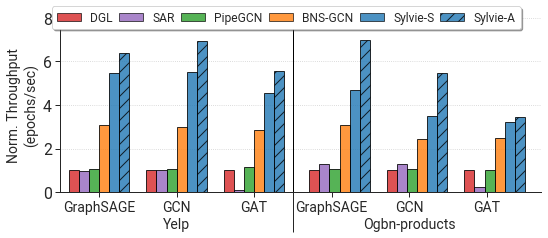

In [14]:
# def trace_analysis(save=False):
cmp = sns.color_palette("tab10")
# grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(7.5, 3.2))

# prepocess data
reddit_n4 = pd.read_csv(f"./results/speed_pcie4_oregon/reddit_n8.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/speed_pcie4_oregon/yelp_n8.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/speed_pcie4_oregon/ogbn-products_n8.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/speed_pcie4_oregon/amazon_n8.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

# bns-gcn baseline data
reddit_n4_bns = pd.read_csv(f"./results/speed_pcie4_oregon/bnsgcn/reddit_n8_p0.1_bns.csv", index_col=False)
reddit_n4_bns = reddit_n4_bns.loc[:, ~reddit_n4_bns.columns.str.contains('^Unnamed')]
yelp_n4_bns = pd.read_csv(f'./results/speed_pcie4_oregon/bnsgcn/yelp_n8_p0.1_bns.csv', index_col=False)
yelp_n4_bns = yelp_n4_bns.loc[:, ~yelp_n4_bns.columns.str.contains('^Unnamed')]
products_n4_bns = pd.read_csv(f'./results/speed_pcie4_oregon/bnsgcn/ogbn-products_n8_p0.1_bns.csv', index_col=False)
products_n4_bns = products_n4_bns.loc[:, ~products_n4_bns.columns.str.contains('^Unnamed')]
amazon_bns = pd.read_csv(f'./results/speed_pcie4_oregon/bnsgcn/amazon_n8_p0.1_bns.csv', index_col=False)
amazon_bns = amazon_bns.loc[:, ~amazon_bns.columns.str.contains('^Unnamed')]

# SAR baseline
sar = pd.read_csv(f"./results/speed_pcie4_v2/sar/sar_n8.csv", index_col=False)
sar = sar.loc[:, ~sar.columns.str.contains('^Unnamed')]
reddit_sar = sar[sar['dataset']=='reddit']
yelp_sar = sar[sar['dataset']=='yelp']
products_sar = sar[sar['dataset']=='ogbn-products']
amazon_sar = sar[sar['dataset']=='amazon']

############################# yelp
fp32_dgl = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
pipegcn = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == True)]
int4my = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == False)]
int4my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == True)]
int1my = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == False)]
int1my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

xtickname = ['GraphSAGE', 'GCN\nYelp', 'GAT', 'GraphSAGE', 'GCN\nOgbn-products', 'GAT']
xlabel = ['Reddit', 'Yelp', 'Ogbn-products', 'Amazon']
y_ticks = np.arange(1, 17, 2)
x = np.arange(1, 7)
x1 = np.arange(1, 4)
width = 0.13

ax1.bar(x1 - width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x1 - width*1.5, fp32_base/yelp_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x1 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x1 + width*0.5, fp32_base/yelp_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x1 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_A=ax1.bar(x1 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
# autolabel(VALUE_A, ax1)

############################# ogbn-products
fp32_dgl = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
pipegcn = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == True)]
int4my = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == False)]
int4my_pipe = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == True)]
int1my = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
int1my_pipe = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x2 = np.arange(4.1, 7.1)
ax1.bar(x2- width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x2 - width*1.5, fp32_base/products_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x2 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x2 + width*0.5, fp32_base/products_n4_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x2 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_B=ax1.bar(x2 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
# autolabel(VALUE_B, ax1)
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")

A = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="DGL")
B = mpatches.Patch(facecolor=cmp[2], alpha=0.8, edgecolor="black", label="PipeGCN")
C = mpatches.Patch(facecolor=cmp[1], alpha=0.8, edgecolor="black", label="BNS-GCN")
# D = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="1-bitGNN(int4)")
# E = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="1-bitGNN-P(int4)")
F = mpatches.Patch(facecolor=cmp[0], alpha=0.8, edgecolor="black", label="Sylvie-S")
G = mpatches.Patch(facecolor=cmp[0], hatch='//', alpha=0.8, edgecolor="black", label="Sylvie-A")
H = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="SAR")

ax1.set_ylabel(f"Norm. Throughput\n(epochs/sec)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(xtickname, fontsize=14)
ax1.set_xlim(0.5, 6.7)
# ax1.set_yticks(np.arange(1, 23, 3))
ax1.set_ylim(0, 8)
sns.despine()
ax1.grid(axis="y", linestyle=":")

ax1.axvline(x=3.5, ls='-', c='k', lw=1)
ax1.xaxis.set_minor_locator(FixedLocator([3.5]))
ax1.xaxis.set_label_coords(.5, -.2)
ax1.tick_params('x', length=40, width=1
, which='minor')

legend1 = ax1.legend(
    handles=[A, H, B, C, F, G],
    bbox_to_anchor=(0.97, 1.1),
    loc=1,
    ncol=6,
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=12,
    columnspacing=0.5,
)

save = True
if save:
    fig.savefig(f"{SAVEPATH}/throughput_1node.pdf", bbox_inches="tight")


In [63]:
reddit_n4 = pd.read_csv(f"./results/speed_pcie4_v2/reddit_n4.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/speed_pcie4_v2/yelp_n4.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/speed_pcie4_v2/ogbn-products_n4.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/speed_pcie4_v2/amazon_n4.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

reddit_n8 = pd.read_csv(f"./results/speed_pcie4_oregon/reddit_n8.csv", index_col=False)
reddit_n8 = reddit_n8.loc[:, ~reddit_n8.columns.str.contains('^Unnamed')]
yelp_n8 = pd.read_csv(f'./results/speed_pcie4_oregon/yelp_n8.csv', index_col=False)
yelp_n8 = yelp_n8.loc[:, ~yelp_n8.columns.str.contains('^Unnamed')]
products_n8 = pd.read_csv(f'./results/speed_pcie4_oregon/ogbn-products_n8.csv', index_col=False)
products_n8 = products_n8.loc[:, ~products_n8.columns.str.contains('^Unnamed')]
amazon_n8 = pd.read_csv(f'./results/speed_pcie4_oregon/amazon_n8.csv', index_col=False)
amazon_n8 = amazon_n8.loc[:, ~amazon_n8.columns.str.contains('^Unnamed')]

sar = pd.read_csv(f"./results/speed_pcie4_v2/sar/sar_n4.csv", index_col=False)
sar = sar.loc[:, ~sar.columns.str.contains('^Unnamed')]

sar_reddit = sar[sar['dataset'] == 'reddit']
fp32_dgl_n4 = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_dgl_n8 = reddit_n8[(reddit_n8['datatype'] == 'fp32') & (reddit_n8['pipeline'] == False)]
sar_n8_reddit = (sar_reddit['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_reddit

sar_yelp = sar[sar['dataset'] == 'yelp']
fp32_dgl_n4 = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
fp32_dgl_n8 = yelp_n8[(yelp_n8['datatype'] == 'fp32') & (yelp_n8['pipeline'] == False)]
sar_n8_yelp = (sar_yelp['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_yelp

sar_products= sar[sar['dataset'] == 'ogbn-products']
fp32_dgl_n4 = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
fp32_dgl_n8 = products_n8[(products_n8['datatype'] == 'fp32') & (products_n8['pipeline'] == False)]
sar_n8_products = (sar_products['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_products

sar_amazon = sar[sar['dataset'] == 'amazon']
fp32_dgl_n4 = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
fp32_dgl_n8 = amazon_n8[(amazon_n8['datatype'] == 'fp32') & (amazon_n8['pipeline'] == False)]
sar_n8_amazon = (sar_amazon['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_amazon


array([8.5748257 , 1.94175851, 4.0006234 ])

N=8, pcie4.0, no eval

1bg-p: [5.8506483  6.35596347 5.20502743]
1bg: [5.00343209 5.31757106 4.49059854]
1bg-p: [4.40021907 4.7701237  2.69626063]
1bg: [3.87497365 4.2063563  2.56703042]
1bg-p: [3.61265324 3.26366561 1.53995987]
1bg: [3.27308977 3.0654443  1.50107632]


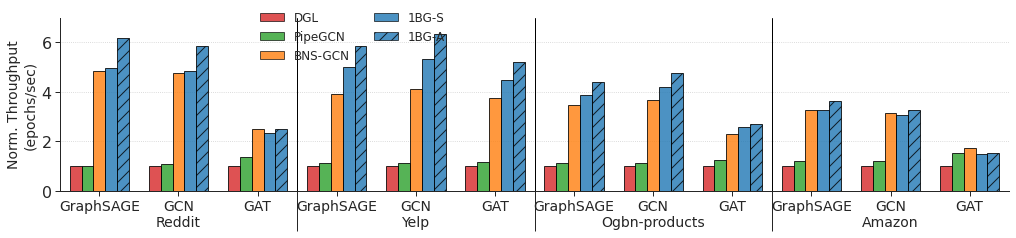

: 

In [3]:
# def trace_analysis(save=False):
cmp = sns.color_palette("tab10")
# grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(14, 3.2))

# prepocess data
reddit_n4 = pd.read_csv(f"./results/speed_pcie4_oregon2/reddit_n8.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/speed_pcie4_oregon2/yelp_n8.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/speed_pcie4_oregon2/ogbn-products_n8.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/speed_pcie4_oregon2/amazon_n8.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

# bns-gcn baseline data
reddit_n4_bns = pd.read_csv(f"./results/speed_pcie4_oregon2/bnsgcn/reddit_n8_p0.1_bns.csv", index_col=False)
reddit_n4_bns = reddit_n4_bns.loc[:, ~reddit_n4_bns.columns.str.contains('^Unnamed')]
yelp_n4_bns = pd.read_csv(f'./results/speed_pcie4_oregon2/bnsgcn/yelp_n8_p0.1_bns.csv', index_col=False)
yelp_n4_bns = yelp_n4_bns.loc[:, ~yelp_n4_bns.columns.str.contains('^Unnamed')]
products_n4_bns = pd.read_csv(f'./results/speed_pcie4_oregon2/bnsgcn/ogbn-products_n8_p0.1_bns.csv', index_col=False)
products_n4_bns = products_n4_bns.loc[:, ~products_n4_bns.columns.str.contains('^Unnamed')]
amazon_bns = pd.read_csv(f'./results/speed_pcie4_oregon2/bnsgcn/amazon_n8_p0.1_bns.csv', index_col=False)
amazon_bns = amazon_bns.loc[:, ~amazon_bns.columns.str.contains('^Unnamed')]

# SAR baseline
sar = pd.read_csv(f"./results/speed_pcie4_v2/sar/sar_n4.csv", index_col=False)
sar = sar.loc[:, ~sar.columns.str.contains('^Unnamed')]


############################# reddit
fp32_dgl = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
pipegcn = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == True)]
int4my = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == False)]
int4my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == True)]
int1my = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == False)]
int1my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == True)]
xtickname = ['GraphSAGE', 'GCN\nReddit', 'GAT', 'GraphSAGE', 'GCN\nYelp', 'GAT', 'GraphSAGE', 'GCN\nOgbn-products', 'GAT', 'GraphSAGE', 'GCN\nAmazon', 'GAT']
xlabel = ['Reddit', 'Yelp', 'Ogbn-products', 'Amazon']
y_ticks = np.arange(1, 17, 2)

x = np.arange(1, 13)
x1 = np.arange(1, 4)
width = 0.15
fp32_base = fp32_dgl['epoch time'].values


ax1.bar(x1 - width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x1 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x1, fp32_base/reddit_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x1 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x1 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/true


ax1.set_ylabel(f"Norm. Throughput\n(epochs/sec)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(xtickname, fontsize=14)
ax1.set_xlim(0.5, 12.5)
# ax1.set_yticks(np.arange(1, 23, 3))
ax1.set_ylim(0, 7)
sns.despine()

ax1.grid(axis="y", linestyle=":")

############################# yelp
fp32_dgl = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
pipegcn = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == True)]
int4my = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == False)]
int4my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == True)]
int1my = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == False)]
int1my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x2 = np.arange(4, 7)
ax1.bar(x2 - width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x2 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x2, fp32_base/yelp_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x2 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x2 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")


############################# ogbn-products
fp32_dgl = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
pipegcn = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == True)]
int4my = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == False)]
int4my_pipe = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == True)]
int1my = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
int1my_pipe = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x3 = np.arange(7, 10)
ax1.bar(x3- width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x3 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x3, fp32_base/products_n4_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x3 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x3 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")


############################# amazon
fp32_dgl = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
pipegcn = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == True)]
int1my = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == False)]
int1my_pipe = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x4 = np.arange(10, 13)
ax1.bar(x4 - width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x4 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x4, fp32_base/amazon_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x4 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x4 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")


A = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="DGL")
B = mpatches.Patch(facecolor=cmp[2], alpha=0.8, edgecolor="black", label="PipeGCN")
C = mpatches.Patch(facecolor=cmp[1], alpha=0.8, edgecolor="black", label="BNS-GCN")
# D = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="1-bitGNN(int4)")
# E = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="1-bitGNN-P(int4)")
F = mpatches.Patch(facecolor=cmp[0], alpha=0.8, edgecolor="black", label="1BG-S")
G = mpatches.Patch(facecolor=cmp[0], hatch='//', alpha=0.8, edgecolor="black", label="1BG-A")

ax1.axvline(x=3.5, ls='-', c='k', lw=1)
ax1.axvline(x=6.5, ls='-', c='k', lw=1)
ax1.axvline(x=9.5, ls='-', c='k', lw=1)
ax1.xaxis.set_minor_locator(FixedLocator([3.5, 6.5, 9.5]))
ax1.xaxis.set_label_coords(.5, -.2)
ax1.tick_params('x', length=40, width=1
, which='minor')

legend1 = ax1.legend(
    handles=[A, B, C, F, G],
    bbox_to_anchor=(0.2, 1.1),
    loc=2,
    ncol=2,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=12,
)


save = False
if save:
    fig.savefig(f"{SAVEPATH}/throughput2.pdf", bbox_inches="tight")


2 nodes, N=8, pcie4.0

reddit:
sar: [0.41606535 0.41540687 0.24965572]
pipegcn: [1.14720164 1.14847209 1.14163585]
bnsgcn: [9.02159645 9.17954958 7.85936282]
1bg-S: [19.89800383 19.96997754 14.86098391]
1bg-A: [25.65832158 26.55930883 21.48674204]
yelp:
sar: [0.37149863 0.37262792 0.20978896]
pipegcn: [1.14717208 1.15446429 1.15422175]
bnsgcn: [8.11193262 8.39952182 8.10536339]
1bg: [17.28594098 18.75850643 17.65585256]
1bg-p: [19.76230742 23.01725723 23.61549156]
ogbn-products:
sar: [0.63952979 0.64585921 0.27427406]
pipegcn: [1.18613212 1.19449232 1.18634324]
bnsgcn: [8.3773735  8.63555125 8.0822033 ]
1bg: [17.50702928 18.35082188 14.5668226 ]
1bg-p: [27.59423726 28.0911049  23.15782444]
amazon:
sar: [0.4327844  0.43073186 0.21006417]
pipegcn: [1.0044691  0.99638585 1.04112362]
bnsgcn: [9.07934542 9.34274592 8.43152231]
1bg: [19.27433116 21.5642719  12.17525103]
1bg-p: [24.01044857 25.59644076 15.19606622]


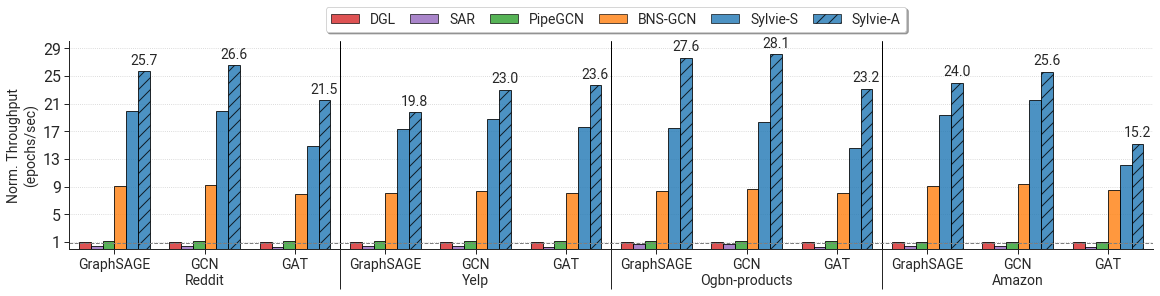

In [10]:

# def trace_analysis(save=False):
cmp = sns.color_palette("tab10")
# grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(16, 4))

# prepocess data
reddit_n4 = pd.read_csv(f"./results/speed_pcie4_v2/reddit_n8_2node.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/speed_pcie4_v2/yelp_n8_2node.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/speed_pcie4_v2/ogbn-products_n8_2node.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/speed_pcie4_v2/amazon_n8_2node.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

# bns-gcn baseline data
reddit_n4_bns = pd.read_csv(f"./results/speed_pcie4_v2/bnsgcn/reddit_n8_p0.1_bns_2node.csv", index_col=False)
reddit_n4_bns = reddit_n4_bns.loc[:, ~reddit_n4_bns.columns.str.contains('^Unnamed')]
yelp_n4_bns = pd.read_csv(f'./results/speed_pcie4_v2/bnsgcn/yelp_n8_p0.1_bns_2node.csv', index_col=False)
yelp_n4_bns = yelp_n4_bns.loc[:, ~yelp_n4_bns.columns.str.contains('^Unnamed')]
products_n4_bns = pd.read_csv(f'./results/speed_pcie4_v2/bnsgcn/ogbn-products_n8_p0.1_bns_2node.csv', index_col=False)
products_n4_bns = products_n4_bns.loc[:, ~products_n4_bns.columns.str.contains('^Unnamed')]
amazon_bns = pd.read_csv(f'./results/speed_pcie4_v2/bnsgcn/amazon_n8_p0.1_bns_2node.csv', index_col=False)
amazon_bns = amazon_bns.loc[:, ~amazon_bns.columns.str.contains('^Unnamed')]

# SAR baseline
sar = pd.read_csv(f"./results/speed_pcie4_v2/sar/sar_n8_2node.csv", index_col=False)
sar = sar.loc[:, ~sar.columns.str.contains('^Unnamed')]
reddit_sar = sar[sar['dataset']=='reddit']
yelp_sar = sar[sar['dataset']=='yelp']
products_sar = sar[sar['dataset']=='ogbn-products']
amazon_sar = sar[sar['dataset']=='amazon']

############################# reddit
fp32_dgl = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
pipegcn = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == True)]
int4my = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == False)]
int4my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == True)]
int1my = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == False)]
int1my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values
print('reddit:')
print(f"sar: {fp32_base/reddit_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/reddit_n4_bns['epoch time'].values}")
print(f"1bg-S: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-A: {fp32_base/int1my_pipe['epoch time'].values}")


x1 = np.arange(1, 4)
width = 0.13

ax1.bar(x1 - width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x1 - width*1.5, fp32_base/reddit_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x1 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x1 + width*0.5, fp32_base/reddit_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x1 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_A=ax1.bar(x1 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/true
autolabel(VALUE_A, ax1)

xtickname = ['GraphSAGE', 'GCN\nReddit', 'GAT', 'GraphSAGE', 'GCN\nYelp', 'GAT', 'GraphSAGE', 'GCN\nOgbn-products', 'GAT', 'GraphSAGE', 'GCN\nAmazon', 'GAT']
xlabel = ['Reddit', 'Yelp', 'Ogbn-products', 'Amazon']
y_ticks = np.arange(1, 17, 2)
x = np.arange(1, 13)
ax1.set_ylabel(f"Norm. Throughput\n(epochs/sec)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(xtickname, fontsize=14)
ax1.set_xlim(0.5, 12.5)
ax1.set_yticks(np.arange(1, 33, 4))
ax1.set_ylim(0, 30)
sns.despine()

ax1.grid(axis="y", linestyle=":")

############################# yelp
fp32_dgl = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
pipegcn = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == True)]
int4my = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == False)]
int4my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == True)]
int1my = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == False)]
int1my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x2 = np.arange(4, 7)
ax1.bar(x2 - width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x2 - width*1.5, fp32_base/yelp_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x2 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x2 + width*0.5, fp32_base/yelp_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x2 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_B=ax1.bar(x2 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
autolabel(VALUE_B, ax1)

print('yelp:')
print(f"sar: {fp32_base/yelp_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/yelp_n4_bns['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")

############################# ogbn-products
fp32_dgl = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
pipegcn = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == True)]
int4my = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == False)]
int4my_pipe = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == True)]
int1my = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
int1my_pipe = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x3 = np.arange(7, 10)
ax1.bar(x3- width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x3 - width*1.5, fp32_base/products_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x3 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x3 + width*0.5, fp32_base/products_n4_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x3 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_C=ax1.bar(x3 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
autolabel(VALUE_C, ax1)
print(f'ogbn-products:')
print(f"sar: {fp32_base/products_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/products_n4_bns['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")

############################# amazon
fp32_dgl = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
pipegcn = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == True)]
int1my = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == False)]
int1my_pipe = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x4 = np.arange(10, 13)
ax1.bar(x4 - width*2.5, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x4 - width*1.5, fp32_base/amazon_sar['epoch time'].values, width=width, label='SAR', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4])
ax1.bar(x4 - width*0.5, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x4 + width*0.5, fp32_base/amazon_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x4 + width*1.5, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
VALUE_D=ax1.bar(x4 + width*2.5, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
autolabel(VALUE_D, ax1)
print('amazon:')
print(f"sar: {fp32_base/amazon_sar['epoch time'].values}")
print(f"pipegcn: {fp32_base/pipegcn['epoch time'].values}")
print(f"bnsgcn: {fp32_base/amazon_bns['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")


A = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="DGL")
B = mpatches.Patch(facecolor=cmp[2], alpha=0.8, edgecolor="black", label="PipeGCN")
C = mpatches.Patch(facecolor=cmp[1], alpha=0.8, edgecolor="black", label="BNS-GCN")
# D = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="1-bitGNN(int4)")
# E = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="1-bitGNN-P(int4)")
F = mpatches.Patch(facecolor=cmp[0], alpha=0.8, edgecolor="black", label="Sylvie-S")
G = mpatches.Patch(facecolor=cmp[0], hatch='//', alpha=0.8, edgecolor="black", label="Sylvie-A")
H = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="SAR")

ax1.axvline(x=3.5, ls='-', c='k', lw=1)
ax1.axvline(x=6.5, ls='-', c='k', lw=1)
ax1.axvline(x=9.5, ls='-', c='k', lw=1)
ax1.xaxis.set_minor_locator(FixedLocator([3.5, 6.5, 9.5]))
ax1.xaxis.set_label_coords(.5, -.2)
ax1.tick_params('x', length=40, width=1
, which='minor')
ax1.axhline(y=0.9, ls='--', c=cmp[7], lw=1)

legend1 = ax1.legend(
    handles=[A, H, B, C, F, G],
    bbox_to_anchor=(0.23, 1.2),
    loc=2,
    ncol=6,
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=14,
    columnspacing=1,
)


save = True
if save:
    fig.savefig(f"{SAVEPATH}/throughput.pdf", bbox_inches="tight")


Final version

1bg-p: [ 9.5741535   9.51936498 14.38341988]
1bg: [7.52654009 8.20150166 9.65180156]
1bg-p: [12.77509117 11.35891105  6.20300838]
1bg: [9.19277658 8.30738611 5.31640073]
1bg-p: [22.72849796  8.42336536 12.8255626 ]
1bg: [18.99228646  7.61315649 12.1705737 ]


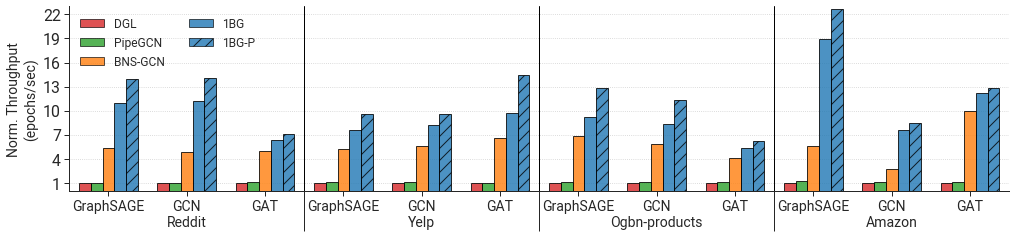

In [20]:
# def trace_analysis(save=False):
cmp = sns.color_palette("tab10")
# grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(14, 3.2))

# prepocess data
reddit_n4 = pd.read_csv(f"./results/reddit_n7_pcie3.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/yelp_n7_pcie3.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/ogbn-products_n7_pcie3.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/amazon_n7_pcie3.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

# bns-gcn baseline data
reddit_n4_bns = pd.read_csv(f"./results/bnsgcn_base/reddit_n7_p0.10_bns.csv", index_col=False)
reddit_n4_bns = reddit_n4_bns.loc[:, ~reddit_n4_bns.columns.str.contains('^Unnamed')]
yelp_n4_bns = pd.read_csv(f'./results/bnsgcn_base/yelp_n7_p0.10_bns.csv', index_col=False)
yelp_n4_bns = yelp_n4_bns.loc[:, ~yelp_n4_bns.columns.str.contains('^Unnamed')]
products_n4_bns = pd.read_csv(f'./results/bnsgcn_base/ogbn-products_n7_p0.10_bns.csv', index_col=False)
products_n4_bns = products_n4_bns.loc[:, ~products_n4_bns.columns.str.contains('^Unnamed')]
amazon_bns = pd.read_csv(f'./results/bnsgcn_base/amazon_n6_p0.10_bns.csv', index_col=False)
amazon_bns = amazon_bns.loc[:, ~amazon_bns.columns.str.contains('^Unnamed')]

############################# reddit
fp32_dgl = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
pipegcn = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == True)]
int4my = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == False)]
int4my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int4') & (reddit_n4['pipeline'] == True)]
int1my = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == False)]
int1my_pipe = reddit_n4[(reddit_n4['datatype'] == 'int1') & (reddit_n4['pipeline'] == True)]
xtickname = ['GraphSAGE', 'GCN\nReddit', 'GAT', 'GraphSAGE', 'GCN\nYelp', 'GAT', 'GraphSAGE', 'GCN\nOgbn-products', 'GAT', 'GraphSAGE', 'GCN\nAmazon', 'GAT']
xlabel = ['Reddit', 'Yelp', 'Ogbn-products', 'Amazon']
y_ticks = np.arange(1, 17, 2)

x = np.arange(1, 13)
x1 = np.arange(1, 4)
width = 0.15
fp32_base = fp32_dgl['epoch time'].values


ax1.bar(x1 - width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x1 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x1, fp32_base/reddit_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x1 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x1 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/true


ax1.set_ylabel(f"Norm. Throughput\n(epochs/sec)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(xtickname, fontsize=14)
ax1.set_xlim(0.5, 12.5)
ax1.set_yticks(np.arange(1, 23, 3))
ax1.set_ylim(0, 23)
sns.despine()

ax1.grid(axis="y", linestyle=":")

############################# yelp
fp32_dgl = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
pipegcn = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == True)]
int4my = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == False)]
int4my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int4') & (yelp_n4['pipeline'] == True)]
int1my = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == False)]
int1my_pipe = yelp_n4[(yelp_n4['datatype'] == 'int1') & (yelp_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x2 = np.arange(4, 7)
ax1.bar(x2 - width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x2 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x2, fp32_base/yelp_n4_bns['epoch time'].values, width=width, label='PipeGCN-GF', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x2 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x2 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")


############################# ogbn-products
fp32_dgl = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
pipegcn = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == True)]
int4my = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == False)]
int4my_pipe = products_n4[(products_n4['datatype'] == 'int4') & (products_n4['pipeline'] == True)]
int1my = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
int1my_pipe = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x3 = np.arange(7, 10)
ax1.bar(x3- width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x3 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x3, fp32_base/products_n4_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x3 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x3 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")


############################# amazon
fp32_dgl = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
pipegcn = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == True)]
int1my = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == False)]
int1my_pipe = amazon[(amazon['datatype'] == 'int1') & (amazon['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values

x4 = np.arange(10, 13)
ax1.bar(x4 - width*2, 1, width=width, label='DGL', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax1.bar(x4 - width, fp32_base/pipegcn['epoch time'].values, width=width, label='PipeGCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax1.bar(x4, fp32_base/amazon_bns['epoch time'].values, width=width, label='BNS-GCN', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax1.bar(x4 + width, fp32_base/int1my['epoch time'].values, width=width, label='1-bitGNN(int1)', alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]) # INT1/false
ax1.bar(x4 + width*2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='1-bitGNN-P(int1)', alpha=0.8, linewidth=1, edgecolor="k", hatch='//', color=cmp[0]) # INT1/false
print(f"1bg-p: {fp32_base/int1my_pipe['epoch time'].values}")
print(f"1bg: {fp32_base/int1my['epoch time'].values}")


A = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="DGL")
B = mpatches.Patch(facecolor=cmp[2], alpha=0.8, edgecolor="black", label="PipeGCN")
C = mpatches.Patch(facecolor=cmp[1], alpha=0.8, edgecolor="black", label="BNS-GCN")
# D = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="1-bitGNN(int4)")
# E = mpatches.Patch(facecolor=cmp[4], alpha=0.8, edgecolor="black", label="1-bitGNN-P(int4)")
F = mpatches.Patch(facecolor=cmp[0], alpha=0.8, edgecolor="black", label="1BG")
G = mpatches.Patch(facecolor=cmp[0], hatch='//', alpha=0.8, edgecolor="black", label="1BG-P")

ax1.axvline(x=3.5, ls='-', c='k', lw=1)
ax1.axvline(x=6.5, ls='-', c='k', lw=1)
ax1.axvline(x=9.5, ls='-', c='k', lw=1)
ax1.xaxis.set_minor_locator(FixedLocator([3.5, 6.5, 9.5]))
ax1.xaxis.set_label_coords(.5, -.2)
ax1.tick_params('x', length=40, width=1
, which='minor')

legend1 = ax1.legend(
    handles=[A, B, C, F, G],
    # bbox_to_anchor=(0.75, 0.6),
    loc=2,
    ncol=2,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=12,
)


save = False
if save:
    fig.savefig(f"{SAVEPATH}/throughput2.pdf", bbox_inches="tight")


3 nodes & 2 nodes comparison

ValueError: [(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (1.0, 0.4980392156862745, 0.054901960784313725), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)] is not a valid value for color

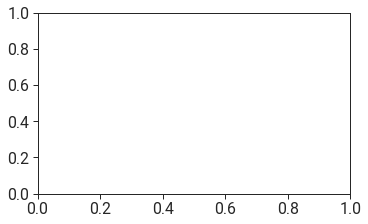

In [11]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 3))

t_2node = [13.3282, 30.80, 13.2689, 1.53, 0.6915, 0.5551]
t_3node = [21.47, 43.96, 20.02, 2.45, 1.07, 0.88]
t_2node_ratio = t_2node[0]/np.array(t_2node)
t_3node_ratio = t_3node[0]/np.array(t_3node)

width = 0.3
x = np.arange(0,6)
A = ax.plot(x - width/2, t_2node_ratio, width=width, label='2 nodes', alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[3], cmp[4], cmp[2], cmp[1], cmp[0], cmp[0]])
B = ax.bar(x + width/2, t_3node_ratio, width=width, label='3 nodes', alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[3], cmp[4], cmp[2], cmp[1], cmp[0], cmp[0]], hatch='//')

ax.set_ylabel(f"Norm. Throughput\n(epochs/sec)", fontsize=14)
ax.set_ylim(0, 25)
# y_ticks = np.arange(0, 14, 2)
# ax.set_yticks(y_ticks)
ax.grid(axis="y", linestyle=":")
# ax.set_xlabel('(b) GAT')
ax.set_xticks(x)
ax.set_xticklabels(['DGL', 'SAR', 'PipeGCN', 'BNS-GCN', '1BG-S', '1BG-A'], fontsize=12)

A = mpatches.Patch(alpha=0.8, edgecolor="black", label="2 nodes")
B = mpatches.Patch(hatch='//', alpha=0.8, edgecolor="black", label="3 nodes")
legend = ax.legend(
    loc=1,
    handles=[A, B],
    bbox_to_anchor=(0.4, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
sns.despine()

save=False
if save:
    fig.savefig(f"{SAVEPATH}/multiserver_compare.pdf", bbox_inches="tight")

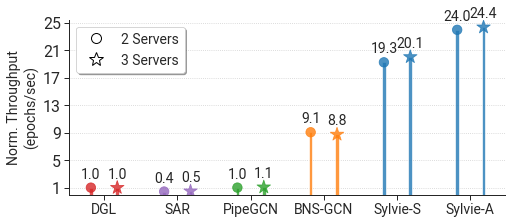

In [13]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height+0.2),
            xytext=(0, 5),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=14,
        )

cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(7, 3))

t_2node = [13.3282, 30.80, 13.2689, 1.4680, 0.6915, 0.5551]
t_3node = [21.47, 43.96, 20.02, 2.45, 1.07, 0.88]
t_2node_ratio = t_2node[0]/np.array(t_2node)
t_3node_ratio = t_3node[0]/np.array(t_3node)

width = 0.05
distance = 0.36
x1 = np.arange(0,6) - distance/2
x2 = np.arange(0,6) + distance/2
A = ax.bar(x1, t_2node_ratio, width=width, label='2 nodes', alpha=0.8, color=[cmp[3], cmp[4], cmp[2], cmp[1], cmp[0], cmp[0]])
C = ax.scatter(x1, t_2node_ratio, s=90, alpha=0.8, color=[cmp[3], cmp[4], cmp[2], cmp[1], cmp[0], cmp[0]], label='2 nodes')
autolabel(A, ax)

B = ax.bar(x2, t_3node_ratio, width=width, label='3 nodes', alpha=0.8, color=[cmp[3], cmp[4], cmp[2], cmp[1], cmp[0], cmp[0]])
D = ax.scatter(x2, t_3node_ratio, s=200, alpha=0.8, color=[cmp[3], cmp[4], cmp[2], cmp[1], cmp[0], cmp[0]], marker='*', label='3 nodes')
autolabel(B, ax)

ax.set_ylabel(f"Norm. Throughput\n(epochs/sec)", fontsize=14)
ax.set_ylim(0, 25.5)
# y_ticks = np.arange(0, 14, 2)
ax.set_yticks(np.arange(1, 26, 4))
ax.grid(axis="y", linestyle=":")
# ax.set_xlabel('(b) GAT')
x = np.arange(0,6)
ax.set_xticks(x)
ax.set_xticklabels(['DGL', 'SAR', 'PipeGCN', 'BNS-GCN', 'Sylvie-S', 'Sylvie-A'], fontsize=14)

A = Line2D([0], [0], marker='o', color='w', label='2 Servers', markerfacecolor='w', markeredgecolor='black', markersize=10)
B = Line2D([0], [0], marker='*', color='w', label='3 Servers', markerfacecolor='w', markeredgecolor='black', markersize=15)
legend = ax.legend(
    # loc=1,
    # C.legend_elements(),
    handles=[A,B],
    # bbox_to_anchor=(0.4, 1),
    ncol=1,
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
# ax.add_artist(legend)
sns.despine()

save=True
if save:
    fig.savefig(f"{SAVEPATH}/multiserver_compare.pdf", bbox_inches="tight")

In [66]:
C.legend_elements()

/opt/conda/lib/python3.8/site-packages/matplotlib/collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


([], [])

SAR data process

In [18]:
reddit_n4 = pd.read_csv(f"./results/speed_pcie4_v2/reddit_n4.csv", index_col=False)
reddit_n4 = reddit_n4.loc[:, ~reddit_n4.columns.str.contains('^Unnamed')]
yelp_n4 = pd.read_csv(f'./results/speed_pcie4_v2/yelp_n4.csv', index_col=False)
yelp_n4 = yelp_n4.loc[:, ~yelp_n4.columns.str.contains('^Unnamed')]
products_n4 = pd.read_csv(f'./results/speed_pcie4_v2/ogbn-products_n4.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]
amazon = pd.read_csv(f'./results/speed_pcie4_v2/amazon_n4.csv', index_col=False)
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]

reddit_n8 = pd.read_csv(f"./results/speed_pcie4_oregon/reddit_n4.csv", index_col=False)
reddit_n8 = reddit_n8.loc[:, ~reddit_n8.columns.str.contains('^Unnamed')]
yelp_n8 = pd.read_csv(f'./results/speed_pcie4_oregon/yelp_n4.csv', index_col=False)
yelp_n8 = yelp_n8.loc[:, ~yelp_n8.columns.str.contains('^Unnamed')]
products_n8 = pd.read_csv(f'./results/speed_pcie4_oregon/ogbn-products_n4.csv', index_col=False)
products_n8 = products_n8.loc[:, ~products_n8.columns.str.contains('^Unnamed')]
amazon_n8 = pd.read_csv(f'./results/speed_pcie4_oregon/amazon_n4.csv', index_col=False)
amazon_n8 = amazon_n8.loc[:, ~amazon_n8.columns.str.contains('^Unnamed')]

sar = pd.read_csv(f"./results/speed_pcie4_v2/sar/sar_n4.csv", index_col=False)
sar = sar.loc[:, ~sar.columns.str.contains('^Unnamed')]

sar_reddit = sar[sar['dataset'] == 'reddit']
fp32_dgl_n4 = reddit_n4[(reddit_n4['datatype'] == 'fp32') & (reddit_n4['pipeline'] == False)]
fp32_dgl_n8 = reddit_n8[(reddit_n8['datatype'] == 'fp32') & (reddit_n8['pipeline'] == False)]
sar_n8_reddit = (sar_reddit['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_reddit

sar_yelp = sar[sar['dataset'] == 'yelp']
fp32_dgl_n4 = yelp_n4[(yelp_n4['datatype'] == 'fp32') & (yelp_n4['pipeline'] == False)]
fp32_dgl_n8 = yelp_n8[(yelp_n8['datatype'] == 'fp32') & (yelp_n8['pipeline'] == False)]
sar_n8_yelp = (sar_yelp['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_yelp

sar_products= sar[sar['dataset'] == 'ogbn-products']
fp32_dgl_n4 = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
fp32_dgl_n8 = products_n8[(products_n8['datatype'] == 'fp32') & (products_n8['pipeline'] == False)]
sar_n8_products = (sar_products['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_products

sar_amazon = sar[sar['dataset'] == 'amazon']
fp32_dgl_n4 = amazon[(amazon['datatype'] == 'fp32') & (amazon['pipeline'] == False)]
fp32_dgl_n8 = amazon_n8[(amazon_n8['datatype'] == 'fp32') & (amazon_n8['pipeline'] == False)]
sar_n8_amazon = (sar_amazon['epoch time'].values/fp32_dgl_n4['epoch time'].values)*fp32_dgl_n8['epoch time'].values
sar_n8_amazon

array([5.92951269, 1.37510246, 3.51220009])

In [19]:
fp32_dgl_n4

,dataset,model,epoch,datatype,pipeline,fixed synchro,rank,epoch time,commu,reduce,compute,accuracy,peak memory
0,amazon,"['graphsage', 4, 128]",2000,fp32,False,NaN,0,0.283561,0.190941,0.027101,0.065519,0.790146,4044.878418
4,amazon,"['gcn', 4, 512]",2000,fp32,False,NaN,0,1.140432,0.897171,0.081309,0.161953,0.566610,8803.224121
8,amazon,"['gat', 3, 128]",1000,fp32,False,NaN,0,0.929024,0.667536,0.173349,0.088138,0.434335,3797.416992


# PCIE4.0 result of PipeGCN

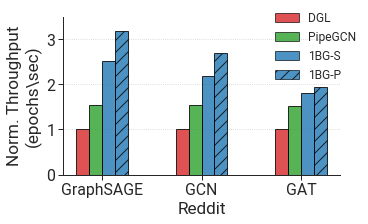

In [138]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 3))

x = np.arange(1, 4)
# prepocess data
products_n4 = pd.read_csv(f'./results/reddit_n4.csv', index_col=False)
products_n4 = products_n4.loc[:, ~products_n4.columns.str.contains('^Unnamed')]

fp32_dgl = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == False)]
pipegcn = products_n4[(products_n4['datatype'] == 'fp32') & (products_n4['pipeline'] == True)]
int1my = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == False)]
int1my_pipe = products_n4[(products_n4['datatype'] == 'int1') & (products_n4['pipeline'] == True)]
fp32_base = fp32_dgl['epoch time'].values
xtickname = ['GraphSAGE', 'GCN', 'GAT']

width = 0.13
p1 = ax.bar(x-width*3/2, 1, width=width, label='dgl', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[3]])
p2 = ax.bar(x-width/2, fp32_base/pipegcn['epoch time'].values, width=width, label='pipegcn', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[2]])
p3 = ax.bar(x+width/2, fp32_base/int1my['epoch time'].values, width=width, label='int1', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[0]])
p4 = ax.bar(x+width*3/2, fp32_base/int1my_pipe['epoch time'].values, width=width, label='int1-P', hatch='//', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[0]])

ax.set_ylabel(f"Norm. Throughput\n(epochs\sec)")
ax.set_xticks(x)
ax.set_xlabel(f"Reddit")
ax.set_xticklabels(xtickname)
ax.set_ylim(0, 3.5)
ax.grid(axis="y", linestyle=":")

sns.despine()

A = mpatches.Patch(facecolor=cmp[3], alpha=0.8, edgecolor="black", label="DGL")
B = mpatches.Patch(facecolor=cmp[2], alpha=0.8, edgecolor="black", label="PipeGCN")
C = mpatches.Patch(facecolor=cmp[0], alpha=0.8, edgecolor="black", label="1BG-S")
D = mpatches.Patch(facecolor=cmp[0], alpha=0.8, hatch='//', edgecolor="black", label="1BG-P")
legend = ax.legend(
    loc=1,
    handles=[A,B,C,D],
    bbox_to_anchor=(1.1, 1.1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=12,
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/pipegcn_pcie4.pdf", bbox_inches="tight")

# Test accuracy convergence

Reddit + Products, fixed synchro

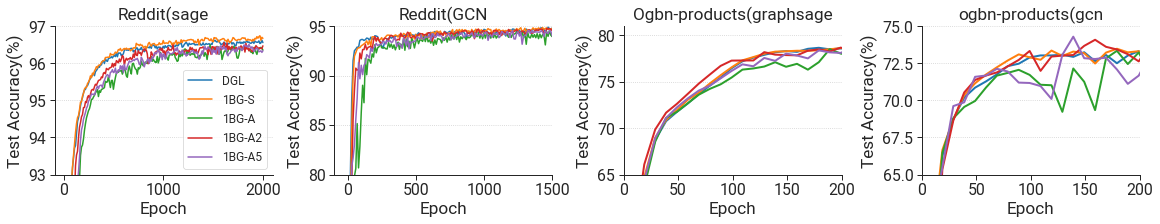

In [58]:
grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(16, 3))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_int1_graphsage_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_100.csv')
x = dgl_df['epoch']

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax1.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5, color=cmp[2])
ax1.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=1.5, color=cmp[3])
ax1.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=1.5, color=cmp[4])
# ax1.plot(x, int1T10_df['acc']*100, label='1BG-A10', linewidth=2, color=cmp[5])
# ax1.plot(x, int1T20_df['acc']*100, label='1BG-A20', linewidth=2, color=cmp[6])
# ax1.plot(x, int1T100_df['acc']*100, label='1BG-A100', linewidth=2, color=cmp[7])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Test Accuracy(%)")
ax1.set_ylim(93, 97)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(sage')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_fp32_gcn_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_100.csv')
x = dgl_df['epoch']

ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax2.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax2.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5,color=cmp[2])
ax2.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=1.5, color=cmp[3])
ax2.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=1.5, color=cmp[4])
ax2.set_xlabel(f"Epoch")
ax2.set_ylabel(f"Test Accuracy(%)")
ax2.set_ylim(80, 95)
ax2.set_xlim(-100, 1500)
ax2.grid(axis="y", linestyle=":")
# ax2.legend(loc=0, fontsize=12)
ax2.set_title('Reddit(GCN')
sns.despine()

# Figure 3
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_graphsage_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_graphsage_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4/ogbn-products_n4_int1_graphsage_0.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_graphsage_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_graphsage_int1_5.csv')
x = dgl_df['epoch']

ax3.plot(x, dgl_df['acc']*100, label='DGL', linewidth=2, color=cmp[0])
ax3.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=2, color=cmp[1])
ax3.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=2, color=cmp[2])
ax3.plot(x, int1T2_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[3])
ax3.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[4])
ax3.set_xlabel(f"Epoch")
ax3.set_ylabel(f"Test Accuracy(%)")
ax3.set_ylim(65, 81)
ax3.set_xlim(0, 200)
ax3.grid(axis="y", linestyle=":")
# ax3.legend(loc=0, fontsize=12)
ax3.set_title('Ogbn-products(graphsage')
sns.despine()

# Figure 4
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_gcn_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_gcn_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_gcn_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_gcn_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_gcn_int1_5.csv')
x = int1T_df['epoch']

ax4.plot(x, dgl_df['acc']*100, label='DGL', linewidth=2, color=cmp[0])
ax4.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=2, color=cmp[1])
ax4.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=2,color=cmp[2])
ax4.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=2, color=cmp[3])
ax4.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[4])
ax4.set_xlabel(f"Epoch")
ax4.set_ylabel(f"Test Accuracy(%)")
ax4.set_ylim(65, 75)
ax4.set_xlim(0, 200)
ax4.grid(axis="y", linestyle=":")
# ax4.legend(loc=0, fontsize=12)
ax4.set_title('ogbn-products(gcn')
sns.despine()

save = False
if save:
    fig.savefig(f"{SAVEPATH}/trace_analysis.pdf", bbox_inches="tight")


Reddit + Yelp, fixed synchro

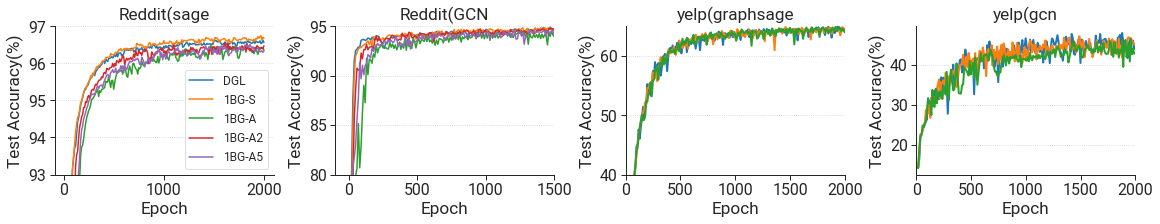

In [103]:
grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(16, 3))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_int1_graphsage_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_100.csv')
x = dgl_df['epoch']

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax1.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5, color=cmp[2])
ax1.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=1.5, color=cmp[3])
ax1.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=1.5, color=cmp[4])
# ax1.plot(x, int1T10_df['acc']*100, label='1BG-A10', linewidth=2, color=cmp[5])
# ax1.plot(x, int1T20_df['acc']*100, label='1BG-A20', linewidth=2, color=cmp[6])
# ax1.plot(x, int1T100_df['acc']*100, label='1BG-A100', linewidth=2, color=cmp[7])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Test Accuracy(%)")
ax1.set_ylim(93, 97)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(sage')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_fp32_gcn_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_100.csv')
x = dgl_df['epoch']

ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax2.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax2.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5,color=cmp[2])
ax2.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=1.5, color=cmp[3])
ax2.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=1.5, color=cmp[4])
ax2.set_xlabel(f"Epoch")
ax2.set_ylabel(f"Test Accuracy(%)")
ax2.set_ylim(80, 95)
ax2.set_xlim(-100, 1500)
ax2.grid(axis="y", linestyle=":")
# ax2.legend(loc=0, fontsize=12)
ax2.set_title('Reddit(GCN')
sns.despine()

# Figure 3
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_graphsage_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_graphsage_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_graphsage_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_graphsage_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_graphsage_int1_5.csv')
x = dgl_df['epoch']

ax3.plot(x, dgl_df['acc']*100, label='DGL', linewidth=2, color=cmp[0])
ax3.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=2, color=cmp[1])
ax3.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=2, color=cmp[2])
# ax3.plot(x, int1T2_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[3])
# ax3.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[4])
ax3.set_xlabel(f"Epoch")
ax3.set_ylabel(f"Test Accuracy(%)")
ax3.set_ylim(40, 65)
ax3.set_xlim(0, 2000)
ax3.grid(axis="y", linestyle=":")
# ax3.legend(loc=0, fontsize=12)
ax3.set_title('yelp(graphsage')
sns.despine()

# Figure 4
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gcn_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gcn_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gcn_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gcn_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gcn_int1_5.csv')
x = int1T_df['epoch']

ax4.plot(x, dgl_df['acc']*100, label='DGL', linewidth=2, color=cmp[0])
ax4.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=2, color=cmp[1])
ax4.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=2,color=cmp[2])
# ax4.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=2, color=cmp[3])
# ax4.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[4])
ax4.set_xlabel(f"Epoch")
ax4.set_ylabel(f"Test Accuracy(%)")
# ax4.set_ylim(0, 50)
ax4.set_xlim(0, 2000)
ax4.grid(axis="y", linestyle=":")
# ax4.legend(loc=0, fontsize=12)
ax4.set_title('yelp(gcn')
sns.despine()

save = False
if save:
    fig.savefig(f"{SAVEPATH}/trace_analysis.pdf", bbox_inches="tight")


Reddit, fixed synchro

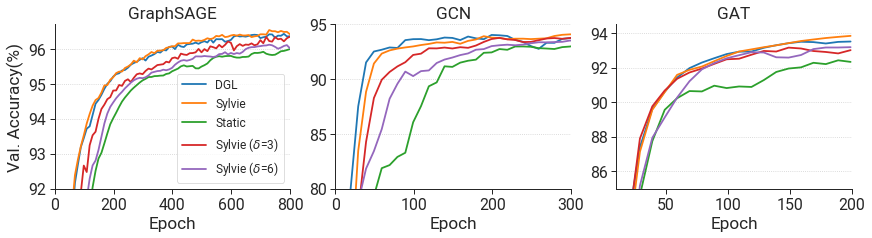

In [212]:
grid_params=dict(width_ratios=[1, 1, 1])
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(12, 3.2))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_int1_graphsage_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_100.csv')
x = dgl_df['epoch']

int1T_smooth = savgol_filter(int1T_df['acc']*100, 5, 1, mode= 'nearest')
int1T5_smooth = savgol_filter(int1T5_df['acc']*100, 3, 1, mode= 'nearest')

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.8, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='Sylvie', linewidth=1.8, color=cmp[1])
ax1.plot(x, int1T_smooth, label='Static', linewidth=1.8, color=cmp[2])
ax1.plot(x, int1T2_df['acc']*100, label='Sylvie ($\delta$=3)', linewidth=1.8, color=cmp[3])
ax1.plot(x, int1T5_smooth, label='Sylvie ($\delta$=6)', linewidth=1.8, color=cmp[4])
# ax1.plot(x, int1T10_df['acc']*100, label='1BG-A10', linewidth=2, color=cmp[5])
# ax1.plot(x, int1T20_df['acc']*100, label='1BG-A20', linewidth=2, color=cmp[6])
# ax1.plot(x, int1T100_df['acc']*100, label='1BG-A100', linewidth=2, color=cmp[7])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Val. Accuracy(%)")
ax1.set_ylim(92, 96.7)
ax1.set_xlim(0, 800)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('GraphSAGE')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_fp32_gcn_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_100.csv')
x = dgl_df['epoch']

int1_smooth = savgol_filter(int1_df['acc']*100, 3, 1, mode= 'nearest')
int1T_smooth = savgol_filter(int1T_df['acc']*100, 3, 1, mode= 'nearest')
int1T2_smooth = savgol_filter(int1T2_df['acc']*100, 3, 1, mode= 'nearest')
int1T5_smooth = savgol_filter(int1T5_df['acc']*100, 3, 1, mode= 'nearest')

ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.8, color=cmp[0])
ax2.plot(x, int1_smooth, label='Sylvie', linewidth=1.8, color=cmp[1])
ax2.plot(x, int1T_smooth , label='Static', linewidth=1.8,color=cmp[2])
ax2.plot(x, int1T2_smooth, label='Sylvie ($\delta$=3)', linewidth=1.8, color=cmp[3])
ax2.plot(x, int1T5_smooth, label='Sylvie ($\delta$=6)', linewidth=1.8, color=cmp[4])
ax2.set_xlabel(f"Epoch")
# ax2.set_ylabel(f"Test Accuracy(%)")
ax2.set_ylim(80, 95)
ax2.set_xlim(0, 300)
ax2.grid(axis="y", linestyle=":")
# ax2.legend(loc=0, fontsize=12)
ax2.set_title('GCN')
sns.despine()

# Figure 3
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_5.csv')
x = dgl_df['epoch']

int1_smooth = savgol_filter(int1_df['acc']*100, 3, 1, mode= 'nearest')
int1T_smooth = savgol_filter(int1T_df['acc']*100, 3, 1, mode= 'nearest')
int1T5_smooth = savgol_filter(int1T5_df['acc']*100, 3, 1, mode= 'nearest')

ax3.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.8, color=cmp[0])
ax3.plot(x, int1_smooth, label='Sylvie', linewidth=1.8, color=cmp[1])
ax3.plot(x, int1T_smooth, label='Static', linewidth=1.8, color=cmp[2])
ax3.plot(x, int1T2_df['acc']*100, label='Sylvie ($\delta$=5)', linewidth=1.8, color=cmp[3])
ax3.plot(x, int1T5_smooth, label='Sylvie ($\delta$=10)', linewidth=1.8, color=cmp[4])
ax3.set_xlabel(f"Epoch")
# ax3.set_ylabel(f"Val. Accuracy(%)")
ax3.set_ylim(85, 94.5)
ax3.set_xlim(10, 200)
ax3.grid(axis="y", linestyle=":")
# ax3.legend(loc=0, fontsize=12)
ax3.set_title('GAT')
sns.despine()

save = True
if save:
    fig.savefig(f"{SAVEPATH}/sensitivity.pdf", bbox_inches="tight")


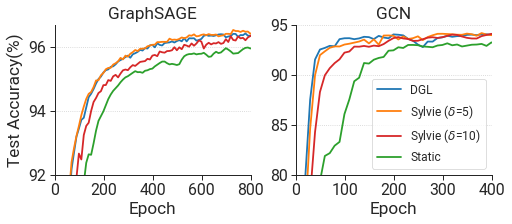

In [222]:
grid_params=dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(7, 3))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_int1_graphsage_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_100.csv')
x = dgl_df['epoch']

int1T_smooth = savgol_filter(int1T_df['acc']*100, 3, 1, mode= 'nearest')
int1T5_smooth = savgol_filter(int1T5_df['acc']*100, 3, 1, mode= 'nearest')

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.8, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='Sylvie-5', linewidth=1.8, color=cmp[1])
ax1.plot(x, int1T2_df['acc']*100, label='sylvie-10', linewidth=1.8, color=cmp[3])
ax1.plot(x, int1T_smooth, label='static', linewidth=1.8, color=cmp[2])

# ax1.plot(x, int1T5_smooth, label='1BG-A5', linewidth=1.8, color=cmp[4])
# ax1.plot(x, int1T10_df['acc']*100, label='1BG-A10', linewidth=2, color=cmp[5])
# ax1.plot(x, int1T20_df['acc']*100, label='1BG-A20', linewidth=2, color=cmp[6])
# ax1.plot(x, int1T100_df['acc']*100, label='1BG-A100', linewidth=2, color=cmp[7])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Test Accuracy(%)")
ax1.set_ylim(92, 96.7)
ax1.set_xlim(0, 800)
ax1.grid(axis="y", linestyle=":")
ax1.set_title('GraphSAGE')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_fp32_gcn_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_True.csv')
int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_2.csv')
int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_5.csv')
int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_10.csv')
int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_20.csv')
int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_100.csv')
x = dgl_df['epoch']

int1T_smooth = savgol_filter(int1T_df['acc']*100, 3, 1, mode= 'nearest')
int1T2_smooth = savgol_filter(int1T2_df['acc']*100, 3, 1, mode= 'nearest')
int1T5_smooth = savgol_filter(int1T5_df['acc']*100, 3, 1, mode= 'nearest')

A=ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.8, color=cmp[0])
B=ax2.plot(x, int1_df['acc']*100, label='Sylvie ($\delta$=5)', linewidth=1.8, color=cmp[1])
D=ax2.plot(x, int1T2_smooth, label='Sylvie ($\delta$=10)', linewidth=1.8, color=cmp[3])
C=ax2.plot(x, int1T_smooth , label='Static', linewidth=1.8,color=cmp[2])

# ax2.plot(x, int1T5_smooth, label='Sylvie ', linewidth=1.8, color=cmp[4])
ax2.set_xlabel(f"Epoch")
# ax2.set_ylabel(f"Test Accuracy(%)")
ax2.set_ylim(80, 95)
ax2.set_xlim(0, 400)
ax2.grid(axis="y", linestyle=":")
ax2.legend(loc=0, fontsize=12)
ax2.set_title('GCN')
sns.despine()

save = True
if save:
    fig.savefig(f"{SAVEPATH}/sensitivity.pdf", bbox_inches="tight")


partiton=4

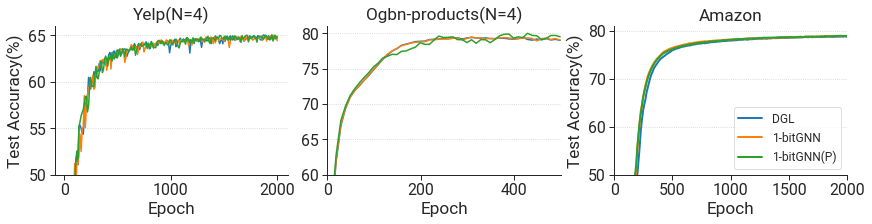

In [132]:
grid_params=dict(width_ratios=[1, 1, 1])
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(12, 3))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_int1_graphsage_True.csv')
x = dgl_df['epoch']

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=1.5, color=cmp[1])
ax1.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=1.5, color=cmp[2])
ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Test Accuracy(%)")
ax1.set_ylim(50, 66)
ax1.grid(axis="y", linestyle=":")
# ax1.legend(loc=0, fontsize=12)
ax1.set_title('Yelp(N=4)')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n4_int1_graphsage_True.csv')
x = dgl_df['epoch']

ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax2.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=1.5, color=cmp[1])
ax2.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=1.5, color=cmp[2])
ax2.set_xlabel(f"Epoch")
# ax2.set_ylabel(f"Test Accuracy(%)")
ax2.set_ylim(60, 81)
ax2.set_yticks(np.arange(60, 81, 5))
ax2.set_xlim(0, 500)
ax2.grid(axis="y", linestyle=":")
# ax2.legend(loc=0, fontsize=12)
ax2.set_title('Ogbn-products(N=4)')
sns.despine()

# Figure 3
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/amazon_n4_graphsage_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/amazon_n4_graphsage_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/amazon_n4_graphsage_int1_True.csv')
x = dgl_df['epoch']

ax3.plot(x, dgl_df['acc']*100, label='DGL', linewidth=2, color=cmp[0])
ax3.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=2, color=cmp[1])
ax3.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=2, color=cmp[2])
ax3.set_xlabel(f"Epoch")
ax3.set_ylabel(f"Test Accuracy(%)")
ax3.set_ylim(50, 81)
ax3.set_xlim(0, 2000)
ax3.grid(axis="y", linestyle=":")
ax3.legend(loc=0, fontsize=12)
ax3.set_title('Amazon')
sns.despine()

save = False
if save:
    fig.savefig(f"{SAVEPATH}/trace_analysis.pdf", bbox_inches="tight")



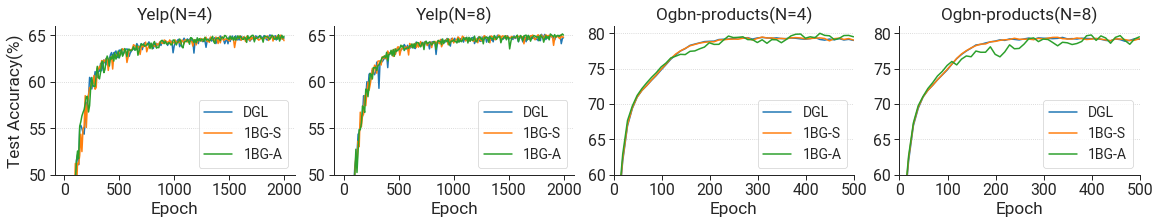

In [5]:
grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(16, 3))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_int1_graphsage_True.csv')
x = dgl_df['epoch']

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax1.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5, color=cmp[2])
ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Test Accuracy(%)")
ax1.set_ylim(50, 66)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=14)
ax1.set_title('Yelp(N=4)')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n7_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n7_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n7_int1_graphsage_True.csv')
x = dgl_df['epoch']

ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax2.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax2.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5,color=cmp[2])
ax2.set_xlabel(f"Epoch")
# ax3.set_ylabel(f"Test Accuracy(%)")
ax2.set_ylim(50, 66)
ax2.grid(axis="y", linestyle=":")
ax2.legend(loc=0, fontsize=14)
ax2.set_title('Yelp(N=8)')
sns.despine()

# Figure 3
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n4_int1_graphsage_True.csv')
x = dgl_df['epoch']

ax3.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax3.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax3.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5, color=cmp[2])
ax3.set_xlabel(f"Epoch")
# ax2.set_ylabel(f"Test Accuracy(%)")
ax3.set_ylim(60, 81)
ax3.set_yticks(np.arange(60, 81, 5))
ax3.set_xlim(0, 500)
ax3.grid(axis="y", linestyle=":")
ax3.legend(loc=0, fontsize=14)
ax3.set_title('Ogbn-products(N=4)')
sns.despine()

# Figure 4
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n7_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n7_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n7_int1_graphsage_True_v2.csv')
x = dgl_df['epoch']

ax4.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax4.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax4.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5, color=cmp[2])
ax4.set_xlabel(f"Epoch")
# ax4.set_ylabel(f"Test Accuracy(%)")
ax4.set_ylim(60, 81)
ax4.set_yticks(np.arange(60, 81, 5))
ax4.set_xlim(0, 500)
ax4.grid(axis="y", linestyle=":")
ax4.legend(loc=0, fontsize=14)
ax4.set_title('Ogbn-products(N=8)')

save = True
if save:
    fig.savefig(f"{SAVEPATH}/testacc.pdf", bbox_inches="tight")

Yelp + Products(SAGE + GCN)

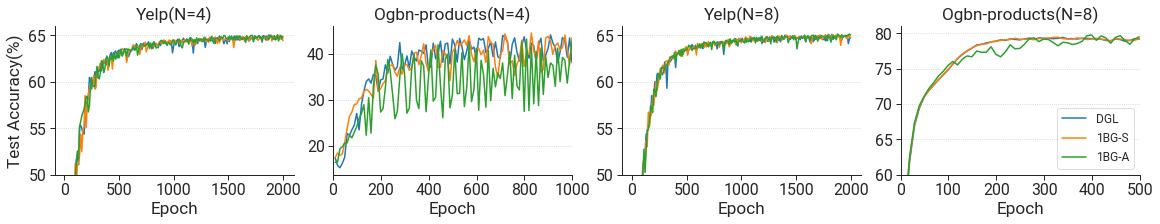

In [128]:
grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(16, 3))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n4_int1_graphsage_True.csv')
x = dgl_df['epoch']

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=1.5, color=cmp[1])
ax1.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=1.5, color=cmp[2])
ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Test Accuracy(%)")
ax1.set_ylim(50, 66)
ax1.grid(axis="y", linestyle=":")
# ax1.legend(loc=0, fontsize=12)
ax1.set_title('Yelp(N=4)')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gat_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gat_int1_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gat_int1_True.csv')
x = dgl_df['epoch']

ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax2.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=1.5, color=cmp[1])
ax2.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=1.5, color=cmp[2])
ax2.set_xlabel(f"Epoch")
# ax2.set_ylabel(f"Test Accuracy(%)")
# ax2.set_ylim(40, 46)
# ax2.set_yticks(np.arange(60, 81, 5))
ax2.set_xlim(0, 1000)
ax2.grid(axis="y", linestyle=":")
# ax2.legend(loc=0, fontsize=12)
ax2.set_title('Ogbn-products(N=4)')
sns.despine()

# Figure 3
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n7_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n7_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/yelp_n7_int1_graphsage_True.csv')
x = dgl_df['epoch']

ax3.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax3.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=1.5, color=cmp[1])
ax3.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=1.5,color=cmp[2])
ax3.set_xlabel(f"Epoch")
# ax3.set_ylabel(f"Test Accuracy(%)")
ax3.set_ylim(50, 66)
ax3.grid(axis="y", linestyle=":")
# ax3.legend(loc=0, fontsize=12)
ax3.set_title('Yelp(N=8)')
sns.despine()

# Figure 4
dgl_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n7_fp32_graphsage_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n7_int1_graphsage_False.csv')
int1T_df = pd.read_csv('./results/testacc_curve_pcie3/ogbn-products_n7_int1_graphsage_True_v2.csv')
x = dgl_df['epoch']

ax4.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax4.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
ax4.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5, color=cmp[2])
ax4.set_xlabel(f"Epoch")
# ax4.set_ylabel(f"Test Accuracy(%)")
ax4.set_ylim(60, 81)
ax4.set_yticks(np.arange(60, 81, 5))
ax4.set_xlim(0, 500)
ax4.grid(axis="y", linestyle=":")
ax4.legend(loc=0, fontsize=12)
ax4.set_title('Ogbn-products(N=8)')

save = True
if save:
    fig.savefig(f"{SAVEPATH}/testacc.pdf", bbox_inches="tight")

GAT

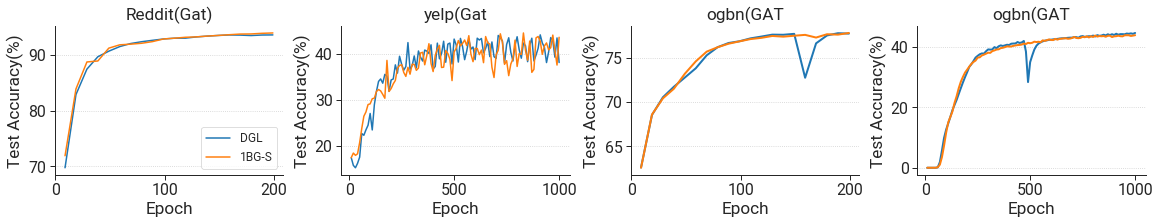

In [47]:
grid_params=dict(width_ratios=[1, 1, 1, 1])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(16, 3))

# Figure 1
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_False.csv')
# int1T_df = pd.read_csv('./results/testacc_curve_pcie3/reddit_n4_int1_graphsage_True.csv')
# int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_2.csv')
# int1T5_df = pd.read_csv('./results/testacc_curve_pcie4/reddit_n4_int1_graphsage_5.csv')
# int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_10.csv')
# int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_20.csv')
# int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_graphsage_int1_100.csv')
x = dgl_df['epoch']

ax1.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax1.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
# ax1.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5, color=cmp[2])
# ax1.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=1.5, color=cmp[3])
# ax1.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=1.5, color=cmp[4])
# ax1.plot(x, int1T10_df['acc']*100, label='1BG-A10', linewidth=2, color=cmp[5])
# ax1.plot(x, int1T20_df['acc']*100, label='1BG-A20', linewidth=2, color=cmp[6])
# ax1.plot(x, int1T100_df['acc']*100, label='1BG-A100', linewidth=2, color=cmp[7])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Test Accuracy(%)")
# ax1.set_ylim(93, 97)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(Gat)')
sns.despine()

# Figure 2
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gat_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/yelp_n4_gat_int1_False.csv')
# int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_True.csv')
# int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_2.csv')
# int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_5.csv')
# int1T10_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_10.csv')
# int1T20_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_20.csv')
# int1T100_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gcn_int1_100.csv')
x = dgl_df['epoch']

ax2.plot(x, dgl_df['acc']*100, label='DGL', linewidth=1.5, color=cmp[0])
ax2.plot(x, int1_df['acc']*100, label='1BG-S', linewidth=1.5, color=cmp[1])
# ax2.plot(x, int1T_df['acc']*100, label='1BG-A', linewidth=1.5,color=cmp[2])
# ax2.plot(x, int1T2_df['acc']*100, label='1BG-A2', linewidth=1.5, color=cmp[3])
# ax2.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=1.5, color=cmp[4])
ax2.set_xlabel(f"Epoch")
ax2.set_ylabel(f"Test Accuracy(%)")
# ax2.set_ylim(80, 95)
# ax2.set_xlim(-100, 1500)
ax2.grid(axis="y", linestyle=":")
# ax2.legend(loc=0, fontsize=12)
ax2.set_title('yelp(Gat')
sns.despine()

# Figure 3
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_gat_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/ogbn-products_n4_gat_int1_False.csv')
# int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_True.csv')
# int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_2.csv')
# int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_5.csv')
x = dgl_df['epoch']

ax3.plot(x, dgl_df['acc']*100, label='DGL', linewidth=2, color=cmp[0])
ax3.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=2, color=cmp[1])
# ax3.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=2, color=cmp[2])
# ax3.plot(x, int1T2_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[3])
# ax3.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[4])
ax3.set_xlabel(f"Epoch")
ax3.set_ylabel(f"Test Accuracy(%)")
# ax3.set_ylim(80, 95)
# ax3.set_xlim(0, 200)
ax3.grid(axis="y", linestyle=":")
# ax3.legend(loc=0, fontsize=12)
ax3.set_title('ogbn(GAT')
sns.despine()

# Figure 4
dgl_df = pd.read_csv('./results/testacc_curve_pcie4_v2/amazon_n4_gat_fp32_False.csv')
int1_df = pd.read_csv('./results/testacc_curve_pcie4_v2/amazon_n4_gat_int1_False.csv')
# int1T_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_True.csv')
# int1T2_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_2.csv')
# int1T5_df = pd.read_csv('./results/testacc_curve_pcie4_v2/reddit_n4_gat_int1_5.csv')
x = dgl_df['epoch']

ax4.plot(x, dgl_df['acc']*100, label='DGL', linewidth=2, color=cmp[0])
ax4.plot(x, int1_df['acc']*100, label='1-bitGNN', linewidth=2, color=cmp[1])
# ax3.plot(x, int1T_df['acc']*100, label='1-bitGNN(P)', linewidth=2, color=cmp[2])
# ax3.plot(x, int1T2_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[3])
# ax3.plot(x, int1T5_df['acc']*100, label='1BG-A5', linewidth=2, color=cmp[4])
ax4.set_xlabel(f"Epoch")
ax4.set_ylabel(f"Test Accuracy(%)")
# ax3.set_ylim(80, 95)
# ax3.set_xlim(0, 200)
ax4.grid(axis="y", linestyle=":")
# ax3.legend(loc=0, fontsize=12)
ax4.set_title('ogbn(GAT')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/trace_analysis.pdf", bbox_inches="tight")


8-JKNet

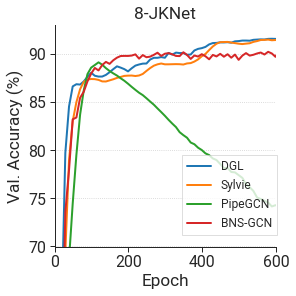

In [211]:

grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(4, 4))

# Figure 1
df_dgl = pd.read_csv('results/testacc_curve_pcie4_v2/reddit_n4_jknet_fp32.csv')
df_sylvie = pd.read_csv('results/testacc_curve_pcie4_v2/reddit_n4_jknet_adap2.csv')
df_pipegcn = pd.read_csv('results/testacc_curve_pcie4_v2/reddit_n4_jknet_fp32_True.csv')
df_bnsgcn = pd.read_csv('results/testacc_curve_pcie4_v2/reddit_n4_jknet_p0.1.csv')
# df_1_p = pd.read_csv('results/reddit_jknet_1_p.csv')

x1 = df_dgl['epoch']
# x2= df_1['epoch']
dgl_smooth = savgol_filter(df_dgl['acc']*100, 3, 1, mode= 'nearest')
sylvie_smooth = savgol_filter(df_sylvie['acc']*100, 5, 1, mode= 'nearest')
pipegcn_smooth = savgol_filter(df_pipegcn['acc']*100, 5, 1, mode= 'nearest')

# ------------------------------------ acc -----------------------------------------------
ax1.plot(x1, dgl_smooth, label='DGL', linewidth=2, color=cmp[0])
ax1.plot(x1, sylvie_smooth, label='Sylvie', linewidth=2, color=cmp[1])
ax1.plot(x1, pipegcn_smooth, label='PipeGCN', linewidth=2, color=cmp[2])
ax1.plot(x1, df_bnsgcn['acc']*100, label='BNS-GCN', linewidth=2, color=cmp[3])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Val. Accuracy (%)")
ax1.set_ylim(70, 93)
ax1.set_xlim(0, 600)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=2,
    bbox_to_anchor=(0.55, 0.44),
    ncol=1,
    frameon=True,
    fancybox=False,
    shadow=False,
    fontsize=12,)
ax1.set_title('8-JKNet')
sns.despine()


save = True
if save:
    fig.savefig(f"{SAVEPATH}/JKNet.pdf", bbox_inches="tight")
    


# Loss vs different bit-widths

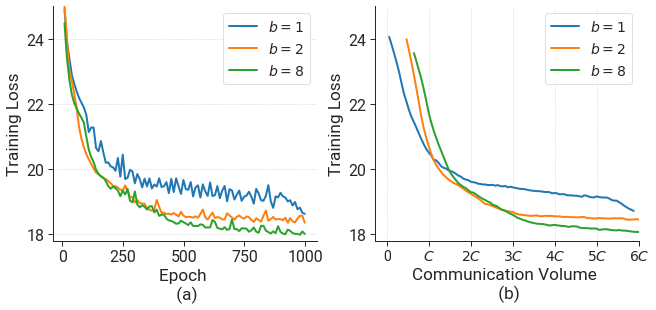

In [23]:
from scipy.signal import savgol_filter


grid_params=dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(9, 4.2))

# Figure 1
dgl_df = pd.read_csv('results/testacc_curve_pcie4/yelp_n4_fp32_gat_False.csv')
int1_df = pd.read_csv('results/testacc_curve_pcie4/yelp_n4_int1_gat_100.csv')
int2_df = pd.read_csv('results/testacc_curve_pcie4_v2/yelp_n4_gat_int1_False.csv')
int4_df = pd.read_csv('results/testacc_curve_pcie4_v2/yelp_n4_gat_int4_False.csv')
int8_df = pd.read_csv('results/testacc_curve_pcie4_v2/yelp_n4_gat_int8_False.csv')

x1 = int1_df['epoch']
x2 = int2_df['epoch']
x8 = int8_df['epoch']

# Figure 1
# accuracy
# ax1.plot(x, dgl_df['acc'], label='FP32', linewidth=1.5, color=cmp[0])
# ax1.plot(x, int1_df['acc'], label='INT1', linewidth=1.5, color=cmp[1])
# ax1.plot(x, int2_df['acc'], label='INT2', linewidth=1.5, color=cmp[2])
# ax1.plot(x1, int4_df['acc'], label='INT4', linewidth=1.5, color=cmp[3])
# ax1.plot(x1, int8_df['acc'], label='INT8', linewidth=1.5, color=cmp[4])

# ax1.plot(x, dgl_df['loss'] / 138441, label='FP32', linewidth=1.5, color=cmp[0])
ax1.plot(x1, int1_df['loss'] / 138441, label=r"$b=1$", linewidth=2, color=cmp[0])  
ax1.plot(x2, int2_df['loss'] / 138441, label=r"$b=2$", linewidth=2, color=cmp[1])
# ax1.plot(x1, int4_df['loss'], label='INT4', linewidth=1.5, color=cmp[3])
ax1.plot(x8, int8_df['loss'], label=r"$b=8$", linewidth=2, color=cmp[2])

ax1.set_xlabel(f"Epoch \n (a)")
ax1.set_ylabel(f"Training Loss")
ax1.set_ylim(17.8, 25)
ax1.set_yticks(np.arange(18, 25, 2))
# ax1.set_xlim(0, 800)
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('GAT')
ax1.legend(loc=0, fontsize=14)
# ax1.set_xlabel('(a)')
sns.despine()

# Figure 2
int1_smooth = savgol_filter(int1_df['loss'].values / 138441, 11, 1, mode= 'nearest')
int2_smooth = savgol_filter(int2_df['loss'].values / 138441, 11, 1, mode= 'nearest')
int8_smooth = savgol_filter(int8_df['loss'].values, 11, 1, mode= 'nearest')
ax2.plot(x1, int1_smooth, label=r"$b=1$", linewidth=2, color=cmp[0])  
ax2.plot(x2 + 70, int2_smooth, label=r"$b=2$", linewidth=2, color=cmp[1])
# ax1.plot(x1, int4_df['loss'], label='INT4', linewidth=1.5, color=cmp[3])
ax2.plot(x8 + 100, int8_smooth, label=r"$b=8$", linewidth=2, color=cmp[2])

ax2.set_xlabel(f"Communication Volume \n (b)")
ax2.set_ylabel(f"Training Loss")
ax2.set_ylim(17.8, 25)
ax2.set_xlim(-50, 999)
ax2.set_yticks(np.arange(18, 25, 2))
ax2.set_xticks(np.arange(0, 1100, 170))
xtickname = ["0", r"$C$", r"$2C$", r"$3C$", r"$4C$", r"$5C$", r"$6C$"]
ax2.set_xticklabels(xtickname, fontsize=14)
ax2.grid(axis="x", linestyle=":")
# ax2.set_title('GAT')
ax2.legend(loc=0, fontsize=14)
# ax2.set_xlabel('(b)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/loss.pdf", bbox_inches="tight")


# Ablation on quant bit

On PCIE3.0

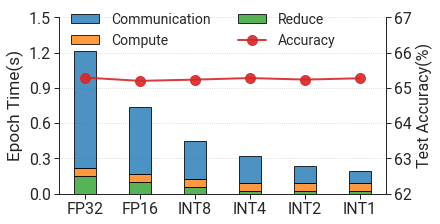

In [33]:
cmp = sns.color_palette("tab10")
# grid_params=dict(width_ratios=[1, 1])
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3))
# fig.subplots_adjust(wspace=0.5, hspace =0)
yelp_n6 = pd.read_csv(f'./results/ablation_yelp_n6_pcie3.csv', index_col=False)
yelp_n6 = yelp_n6.loc[:, ~yelp_n6.columns.str.contains('^Unnamed')]
quant_list = yelp_n6[(yelp_n6['pipeline'] == False)]

x = np.arange(1, 7)
x_labels = ['FP32', 'FP16', 'INT8', 'INT4', 'INT2', 'INT1']

width = 0.4
A = ax.bar(x, quant_list['reduce'], width=width, label='Reduce', alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[2]])
B = ax.bar(x, quant_list['compute'], bottom=quant_list['reduce'].values, width=width, label='Compute', alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[1]])
C = ax.bar(x, quant_list['commu'], bottom=list(map(add, quant_list['reduce'].values, quant_list['compute'].values)), width=width, label='Communication', alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[0]])

ax.set_ylabel(f"Epoch Time(s)")
ax.set_ylim(0, 1.5)
ax.set_yticks(np.arange(0, 1.6, 0.3))
# ax.set_xlabel(f"(a) Reddit")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=16)
ax.grid(axis="y", linestyle=":")

ax1 = ax.twinx()
D, = ax1.plot(x, quant_list['accuracy']*100, label='Accuracy', linewidth=2, marker="o", alpha=0.9, color=cmp[3])

ax1.set_ylabel(f"Test Accuracy(%)", fontsize=16)
ax1.set_ylim(62, 67)
# ax1.set_yticks(np.arange(62, 68.5, 1.5))
# ax1.grid(axis="y", linestyle=":")


# legend = ax.legend(
#     loc=1,
#     handles=[C, B, A],
#     bbox_to_anchor=(1, 1.1),
#     ncol=1,
#     frameon=False,
#     fancybox=True,
#     shadow=True,
#     fontsize=14,
# )
sns.despine(top=True,right=False, left=False, bottom=False)

# Combine plot labels
lns = [C,B,A,D]
labs = [l.get_label() for l in lns]
ax1.legend(
    lns, 
    labs, 
    bbox_to_anchor=(0, 1.1),
    loc=2, 
    ncol=2, 
    frameon=False,
    fontsize=14
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/quantbit.pdf", bbox_inches="tight")

# Multi-node result

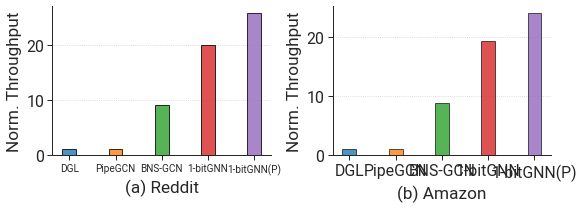

In [9]:
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1, 1])
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 2.8))
# fig.subplots_adjust(wspace=0.5, hspace =0)

x = np.arange(1, 6)
reddit_multi = [1, 1.15, 8.97, 19.9, 25.66]
amazon_multi = [1, 1.00, 8.73, 19.27, 24.01]
x_labels = ['DGL', 'PipeGCN', 'BNS-GCN', '1-bitGNN', '1-bitGNN(P)']

width = 0.3
p1 = ax.bar(x,reddit_multi, width=width, alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[0], cmp[1], cmp[2], cmp[3], cmp[4]])

ax.set_ylabel(f"Norm. Throughput")
ax.set_xlabel(f"(a) Reddit")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=10)
# ax.set_ylim(0, 1.1)
ax.grid(axis="y", linestyle=":")

A = ax2.bar(x, amazon_multi, width, edgecolor="k", alpha=0.8, color = [cmp[0], cmp[1], cmp[2], cmp[3], cmp[4]])

ax2.set_ylabel(f"Norm. Throughput")
ax2.set_xticks(x)
ax2.set_xticklabels(x_labels)
ax2.set_xlabel('(b) Amazon')
ax2.grid(axis="y", linestyle=":")
sns.despine()

save=False
if save:
    fig.savefig(f"{SAVEPATH}/multinode.pdf", bbox_inches="tight")

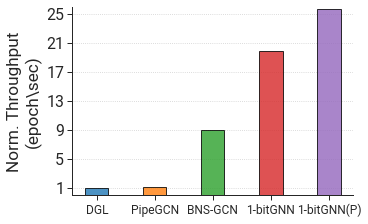

In [11]:
cmp = sns.color_palette("tab10")
# grid_params=dict(width_ratios=[1, 1])
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 3))
# fig.subplots_adjust(wspace=0.5, hspace =0)

x = np.arange(1, 6)
reddit_multi = [1, 1.15, 8.97, 19.9, 25.66]
amazon_multi = [1, 1.00, 8.73, 19.27, 24.01]
x_labels = ['DGL', 'PipeGCN', 'BNS-GCN', '1-bitGNN', '1-bitGNN(P)']

width = 0.4
p1 = ax.bar(x,reddit_multi, width=width, alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[0], cmp[1], cmp[2], cmp[3], cmp[4]])

ax.set_ylabel(f"Norm. Throughput\n(epoch\sec)")
ax.set_yticks(np.arange(1, 26, 4))
# ax.set_xlabel(f"(a) Reddit")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=12)
ax.set_ylim(0, 26)
ax.grid(axis="y", linestyle=":")


sns.despine()

save=False
if save:
    fig.savefig(f"{SAVEPATH}/multinode.pdf", bbox_inches="tight")

# Quant Overhead profile

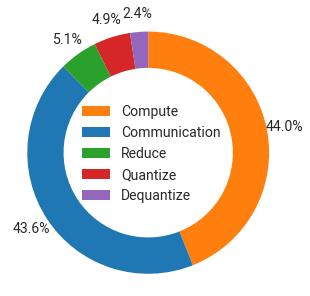

In [3]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4.2, 4))
rect = fig.patch
rect.set_facecolor('white')

t_breakdown = [0.0603, 0.0598, 0.0070, 0.0067, 0.0033]
label = ['Compute', 'Communication', 'Reduce', 'Quantize', 'Dequantize']
colors = [cmp[1], cmp[0], cmp[2], cmp[3], cmp[4]]

ax.pie(t_breakdown, radius=2, labeldistance=1.05, autopct='%.1f%%', textprops={'fontsize': 14}, pctdistance=1.15, startangle=90,counterclock=False,wedgeprops={'width': 0.6,'linewidth': 0}, colors=colors)
# ax.set_title("Time breakdown")
ax.axis("equal")
ax.legend(
    label, 
    bbox_to_anchor=(0.22, 0.73),
    loc=2, 
    ncol=1, 
    frameon=False,
    fancybox=False,
    fontsize=14
)

# plt.legend(loc='upper right')

save=True
if save:
    fig.savefig(f"{SAVEPATH}/chartportion.pdf", bbox_inches="tight")

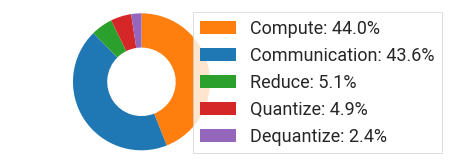

In [41]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 2.2))
rect = fig.patch
rect.set_facecolor('white')

t_breakdown = [0.0603, 0.0598, 0.0070, 0.0067, 0.0033]
label = ['Compute: 44.0%', 'Communication: 43.6%', 'Reduce: 5.1%', 'Quantize: 4.9%', 'Dequantize: 2.4%']
colors = [cmp[1], cmp[0], cmp[2], cmp[3], cmp[4]]

ax.pie(t_breakdown, 
        radius=1, 
        labeldistance=1.05, 
        # autopct='%.1f%%', 
        # textprops={'fontsize': 14}, 
        pctdistance=1.15, 
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.5,'linewidth': 0}, 
        colors=colors)
# ax.set_title("Time breakdown")
ax.axis("equal")
ax.legend(
    label, 
    bbox_to_anchor=(1.65, 0.5),
    loc='center right', 
    ncol=1, 
    frameon=True,
    fancybox=False,
    fontsize=18,
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/chartportion.pdf", bbox_inches="tight", dpi=fig.dpi)

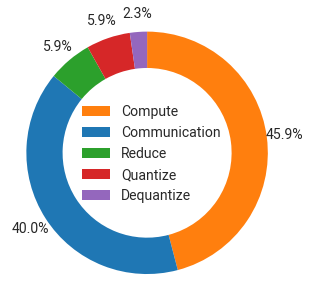

In [42]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4.2, 4))
rect = fig.patch
rect.set_facecolor('white')

t_breakdown = [0.0561, 0.0489, 0.0072, 0.0072, 0.0028]
label = ['Compute', 'Communication', 'Reduce', 'Quantize', 'Dequantize']
colors = [cmp[1], cmp[0], cmp[2], cmp[3], cmp[4]]

ax.pie(t_breakdown, radius=2, labeldistance=1.05, autopct='%.1f%%', textprops={'fontsize': 14}, pctdistance=1.15, startangle=90,counterclock=False,wedgeprops={'width': 0.6,'linewidth': 0}, colors=colors)
# ax.set_title("Time breakdown")
ax.axis("equal")
ax.legend(
    label, 
    bbox_to_anchor=(0.22, 0.73),
    loc=2, 
    ncol=1, 
    frameon=False,
    fancybox=False,
    fontsize=14
)

# plt.legend(loc='upper right')

save=True
if save:
    fig.savefig(f"{SAVEPATH}/chartportion.pdf", bbox_inches="tight")

overhead of 1 node & 2 nodes

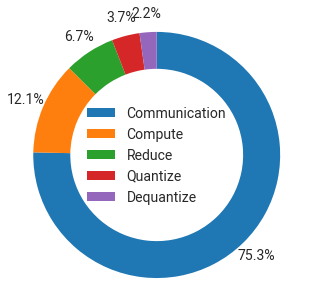

In [109]:
cmp = sns.color_palette("tab10")
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4.2, 4))
rect = fig.patch
rect.set_facecolor('white')

t_breakdown = [0.2807, 0.0452, 0.0248, 0.0136, 0.0083]
label = ['Communication', 'Compute', 'Reduce', 'Quantize', 'Dequantize']
colors = [cmp[0], cmp[1], cmp[2], cmp[3], cmp[4]]

ax.pie(t_breakdown, radius=2, labeldistance=1.05, autopct='%.1f%%', textprops={'fontsize': 14}, pctdistance=1.15, startangle=90,counterclock=False,wedgeprops={'width': 0.6,'linewidth': 0}, colors=colors)
# ax.set_title("Time breakdown")
ax.axis("equal")
ax.legend(
    label, 
    bbox_to_anchor=(0.22, 0.73),
    loc=2, 
    ncol=1, 
    frameon=False,
    fancybox=False,
    fontsize=14
)

# plt.legend(loc='upper right')

save=True
if save:
    fig.savefig(f"{SAVEPATH}/chartportion.pdf", bbox_inches="tight")

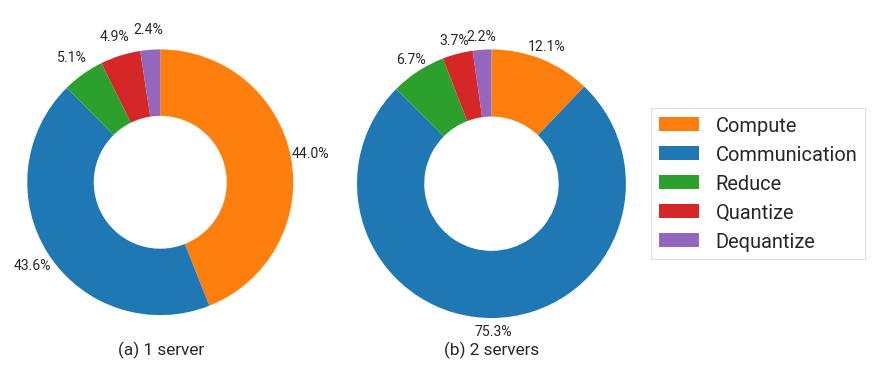

In [68]:
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1, 1])
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(12, 5))
rect = fig.patch
rect.set_facecolor('white')
# fig.subplots_adjust(wspace=0.5, hspace =0)

t_breakdown = [0.0603, 0.0598, 0.0070, 0.0067, 0.0033]
label = ['Compute', 'Communication', 'Reduce', 'Quantize', 'Dequantize']
colors = [cmp[1], cmp[0], cmp[2], cmp[3], cmp[4]]

ax1.pie(t_breakdown, 
        radius=1, 
        labeldistance=1.05, 
        autopct='%.1f%%', 
        textprops={'fontsize': 14}, 
        pctdistance=1.15, 
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.5,'linewidth': 0}, 
        colors=colors)
# ax.set_title("Time breakdown")
ax1.axis("equal")
ax1.set_title('(a) 1 server', y=-0.0005)

t_breakdown = [0.0452, 0.2807, 0.0248, 0.0136, 0.0083]
label = ['Compute', 'Communication', 'Reduce', 'Quantize', 'Dequantize']
colors = [cmp[1], cmp[0], cmp[2], cmp[3], cmp[4]]

ax2.pie(t_breakdown, 
        radius=1, 
        labeldistance=1.05, 
        autopct='%.1f%%', 
        textprops={'fontsize': 14}, 
        pctdistance=1.1, 
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.5,'linewidth': 0}, 
        colors=colors)
ax2.axis("equal")
ax2.set_title('(b) 2 servers', y=-0.0005)

ax2.legend(
    label, 
    bbox_to_anchor=(1.75, 0.5),
    loc='center right', 
    ncol=1, 
    frameon=True,
    fancybox=False,
    fontsize=20,
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/chartportion.pdf", bbox_inches="tight")

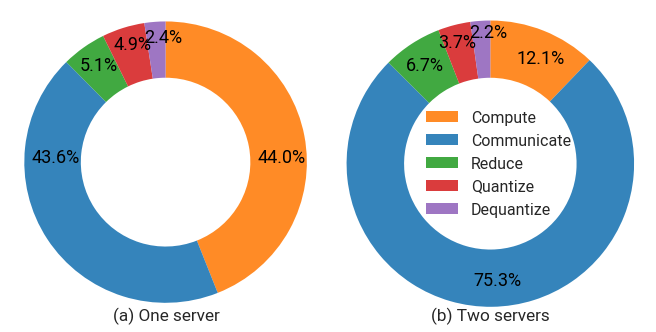

In [7]:
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1, 1])
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(9, 4.5))
rect = fig.patch
rect.set_facecolor('white')
# fig.subplots_adjust(wspace=0.5, hspace =0)

t_breakdown = [0.0603, 0.0598, 0.0070, 0.0067, 0.0033]
label = ['Compute', 'Communication', 'Reduce', 'Quantize', 'Dequantize']
colors = [cmp[1], cmp[0], cmp[2], cmp[3], cmp[4]]

ax1.pie(t_breakdown, 
        radius=1, 
        labeldistance=1.05, 
        # autopct='%.1f%%', 
        # textprops={'fontsize': 16}, 
        # pctdistance=0.89, 
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.4, 'linewidth': 0, 'alpha': 0.9}, 
        colors=colors)

font = {'weight':'normal',
      'color':'black',
      'size':18
}
ax1.text(-0.15, 0.85, '2.4%', fontdict=font)
ax1.text(-0.37, 0.8, '4.9%', fontdict=font)
ax1.text(-0.61, 0.65, '5.1%', fontdict=font)
ax1.text(-0.95, 0, '43.6%', fontdict=font)
ax1.text(0.65, 0, '44.0%', fontdict=font)

ax1.axis("equal")
ax1.set_title('(a) One server', y=-0.02)
# ax1.text(-0.4, -1.12, '(a) One server', fontsize=18)

t_breakdown = [0.0452, 0.2807, 0.0248, 0.0136, 0.0083]
label = ['Compute', 'Communicate', 'Reduce', 'Quantize', 'Dequantize']
colors = [cmp[1], cmp[0], cmp[2], cmp[3], cmp[4]]

ax2.pie(t_breakdown, 
        radius=1, 
        labeldistance=1.05, 
        # autopct='%.1f%%', 
        # textprops={'fontsize': 16}, 
        # pctdistance=1.1, 
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.4,'linewidth': 0, 'alpha': 0.9}, 
        colors=colors)

ax2.text(-0.15, 0.88, '2.2%', fontdict=font)
ax2.text(-0.36, 0.81, '3.7%', fontdict=font)
ax2.text(-0.59, 0.65, '6.7%', fontdict=font)
ax2.text(-0.12, -0.85, '75.3%', fontdict=font)
ax2.text(0.18, 0.7, '12.1%', fontdict=font)

ax2.axis("equal")
ax2.set_title('(b) Two servers', y=-0.02)

ax2.legend(
    label, 
    bbox_to_anchor=(0.8, 0.5),
    loc='center right', 
    ncol=1, 
    frameon=False,
    fancybox=False,
    fontsize=16,
)

save=True
if save:
    fig.savefig(f"{SAVEPATH}/chartportion.pdf", bbox_inches="tight")

Plot absolute error

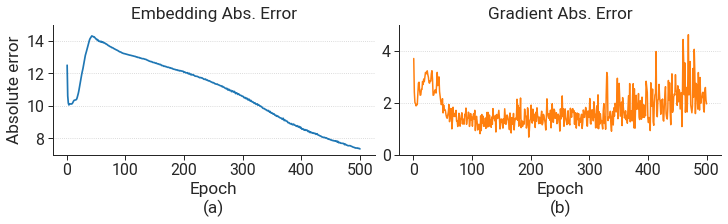

In [36]:
grid_params=dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(10, 3))

# Figure 1
df = pd.read_csv('./results/f_abs_err.csv')
x = np.arange(1, len(df['feature abs err'])+1)

ax1.plot(x, df['feature abs err'], linewidth=1.7, color=cmp[0])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Absolute error")
ax1.set_ylim(7, 15)
ax1.grid(axis="y", linestyle=":")
# ax1.legend(loc=0, fontsize=12)
ax1.set_title('Embedding Abs. Error')
ax1.set_xlabel(f"Epoch\n(a)")


df = pd.read_csv('./results/g_abs_err.csv')
x = np.arange(1, len(df['grad abs err'])+1)

ax2.plot(x, df['grad abs err'], linewidth=1.5, color=cmp[1])

# ax1.plot(x, int1T10_df['acc']*100, label='1BG-A10', linewidth=2, color=cmp[5])
# ax1.plot(x, int1T20_df['acc']*100, label='1BG-A20', linewidth=2, color=cmp[6])
# ax1.plot(x, int1T100_df['acc']*100, label='1BG-A100', linewidth=2, color=cmp[7])

ax2.set_xlabel(f"Epoch")
# ax2.set_ylabel(f"Absolute error")
ax2.set_ylim(0, 5)
ax2.grid(axis="y", linestyle=":")
# ax2.legend(loc=0, fontsize=12)
ax2.set_title('Gradient Abs. Error')
ax2.set_xlabel(f"Epoch\n(b)")

sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/abs_err.pdf", bbox_inches="tight")


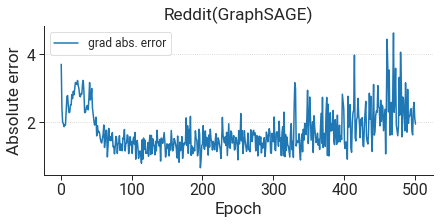

In [18]:
grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(6, 3))

# Figure 1
df = pd.read_csv('./results/g_abs_err.csv')
x = np.arange(1, len(df['grad abs err'])+1)

ax1.plot(x, df['grad abs err'], label='grad abs. error', linewidth=1.5, color=cmp[0])

# ax1.plot(x, int1T10_df['acc']*100, label='1BG-A10', linewidth=2, color=cmp[5])
# ax1.plot(x, int1T20_df['acc']*100, label='1BG-A20', linewidth=2, color=cmp[6])
# ax1.plot(x, int1T100_df['acc']*100, label='1BG-A100', linewidth=2, color=cmp[7])

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Absolute error")
# ax1.set_ylim(7, 15)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(GraphSAGE)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/f_abs_err.pdf", bbox_inches="tight")


# Motivation experiments

appnp

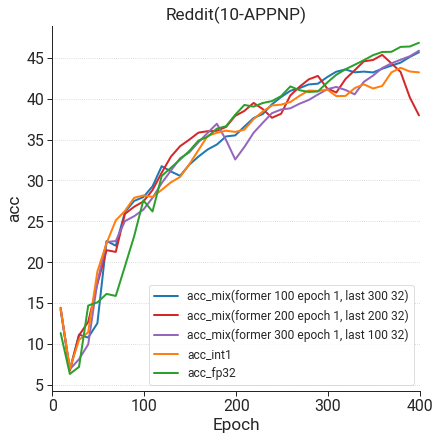

In [46]:
grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(6, 6))

# Figure 1
# df_mix_3l32_7l1= pd.read_csv('results/reddit_appnp_3l32_7l1.csv')
# df_mix_5l32_5l1= pd.read_csv('results/reddit_appnp_5l32_5l1_new.csv')
df_mix_200e1_200e32  = pd.read_csv('results/reddit_appnp_200e1_200e32.csv')
df_mix_200e32_200e1  = pd.read_csv('results/reddit_appnp_200e32_200e1.csv')
df_mix_100e32_300e1  = pd.read_csv('results/reddit_appnp_100e32_300e1.csv')
df_mix_300e1_100e32  = pd.read_csv('results/reddit_appnp_300e1_100e32.csv')
df_mix_100e1_300e32  = pd.read_csv('results/reddit_appnp_100e1_300e32.csv')
df_1 = pd.read_csv('results/reddit_appnp_10l1.csv')
df_fp32 = pd.read_csv('results/reddit_appnp_10l32.csv')
x = df_1['epoch']

# ax1.plot(x, df_mix_200e32_200e1['acc']*100, label='acc_mix(former 200 epoch fp32, last 200 int1)', linewidth=2, color=cmp[0])
# ax1.plot(x, df_mix_100e32_300e1['acc']*100, label='acc_mix(former 100 epoch fp32, last 300 int1)', linewidth=2, color=cmp[4])
# ax1.plot(x, df_mix_200e1_200e32['acc']*100, label='acc_mix(former 200 epoch int1, last 200 fp32)', linewidth=2, color=cmp[3])
ax1.plot(x, df_mix_100e1_300e32['acc']*100, label='acc_mix(former 100 epoch 1, last 300 32)', linewidth=2, color=cmp[0])
ax1.plot(x, df_mix_200e1_200e32['acc']*100, label='acc_mix(former 200 epoch 1, last 200 32)', linewidth=2, color=cmp[3])
ax1.plot(x, df_mix_300e1_100e32['acc']*100, label='acc_mix(former 300 epoch 1, last 100 32)', linewidth=2, color=cmp[4])

ax1.plot(x, df_1['acc']*100, label='acc_int1', linewidth=2, color=cmp[1])
ax1.plot(x, df_fp32['acc']*100, label='acc_fp32', linewidth=2, color=cmp[2])

# ax1.plot(x, df_fp32['loss'], label='acc_fp32', linewidth=2, color=cmp[1])
# ax1.plot(x, df_mix_100e1_300e32['loss'], label='acc_mix(former 100 epoch 1, last 300 32)', linewidth=2, color=cmp[0])
# ax1.plot(x, df_mix_200e1_200e32['loss'], label='acc_mix(former 200 epoch 1, last 200 32)', linewidth=2, color=cmp[3])
# ax1.plot(x, df_mix_300e1_100e32['loss'], label='acc_mix(former 300 epoch 1, last 100 32)', linewidth=2, color=cmp[4])


ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"acc")
# ax1.set_ylim(0, 0.25e6)
ax1.set_xlim(0, 400)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(10-APPNP)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/1.pdf", bbox_inches="tight")


DAGNN

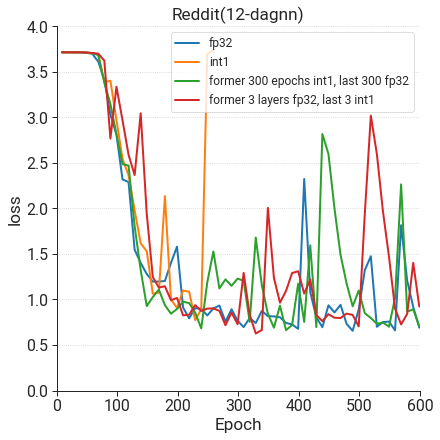

In [55]:
grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(6, 6))

# Figure 1
df_fp32 = pd.read_csv('results/reddit_dagnn_12l32_1.csv')
# df_fp32_2 = pd.read_csv('results/reddit_dagnn_12l32_2.csv')
# df_fp32_3 = pd.read_csv('results/reddit_dagnn_12l32_3.csv')
df_1 = pd.read_csv('results/reddit_dagnn_12l1.csv')
df_300e1_300e32 = pd.read_csv('results/reddit_dagnn_300e1_300e32.csv')
df_6l32_6l1 = pd.read_csv('results/reddit_dagnn_6l32_6l1.csv')

x = df_fp32['epoch']

# ------------------------------------ acc -----------------------------------------------
# ax1.plot(x, df_fp32['acc']*100, label='fp32', linewidth=2, color=cmp[0])
# ax1.plot(x, df_1['acc']*100, label='int1', linewidth=2, color=cmp[1])
# ax1.plot(x, df_300e1_300e32['acc']*100, label='former 300 epochs int1, last 300 fp32', linewidth=2, color=cmp[2])
# ax1.plot(x, df_6l32_6l1['acc']*100, label='former 3 layers fp32, last 3 int1', linewidth=2, color=cmp[3])

# ------------------------------------ loss -----------------------------------------------
ax1.plot(x, df_fp32['loss'], label='fp32', linewidth=2, color=cmp[0])
ax1.plot(x, df_1['loss'], label='int1', linewidth=2, color=cmp[1])
ax1.plot(x, df_300e1_300e32['loss'], label='former 300 epochs int1, last 300 fp32', linewidth=2, color=cmp[2])
ax1.plot(x, df_6l32_6l1['loss'], label='former 3 layers fp32, last 3 int1', linewidth=2, color=cmp[3])


ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"loss")
ax1.set_ylim(0, 4)
ax1.set_xlim(0, 600)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(12-dagnn)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/1.pdf", bbox_inches="tight")
    


jknet

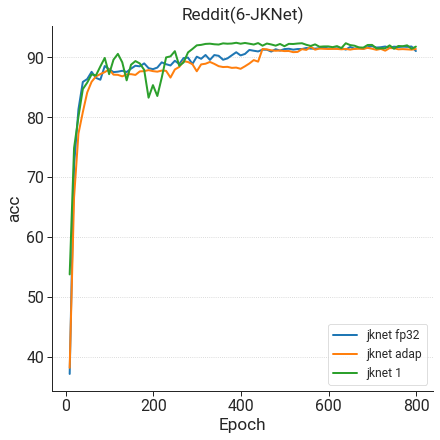

In [20]:
from scipy.signal import savgol_filter

grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(6, 6))

# Figure 1
df_fp32 = pd.read_csv('results/testacc_curve_pcie4_v2/reddit_n4_jknet_fp32.csv')
df_sylvie = pd.read_csv('results/testacc_curve_pcie4_v2/reddit_n4_jknet_adap2.csv')
df_pipegcn = pd.read_csv('results/testacc_curve_pcie4_v2/reddit_n4_jknet_fp32_True.csv')
# df_1_p = pd.read_csv('results/reddit_jknet_1_p.csv')

x1 = df_fp32['epoch']
# x2= df_1['epoch']
# adap_smooth = savgol_filter(df_adap['acc']*100, 9, 1, mode= 'nearest')

# ------------------------------------ acc -----------------------------------------------
ax1.plot(x1, df_fp32['acc']*100, label='jknet fp32', linewidth=2, color=cmp[0])
ax1.plot(x1, df_sylvie['acc']*100, label='jknet adap', linewidth=2, color=cmp[1])
ax1.plot(x1, df_pipegcn['acc']*100, label='jknet 1', linewidth=2, color=cmp[2])
# ax1.plot(x1, df_1_p['acc']*100, label='jknet 1 p', linewidth=2, color=cmp[3])


# ------------------------------------ loss -----------------------------------------------
# ax1.plot(x1, df_fp32['loss'], label='jknet fp32', linewidth=2, color=cmp[0])
# ax1.plot(x1, df_1['loss'], label='jknet 1', linewidth=2, color=cmp[1])



ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"acc")
# ax1.set_ylim(60, 95)
# ax1.set_xlim(0, 100)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(6-JKNet)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/1.pdf", bbox_inches="tight")
    


Error-epoch

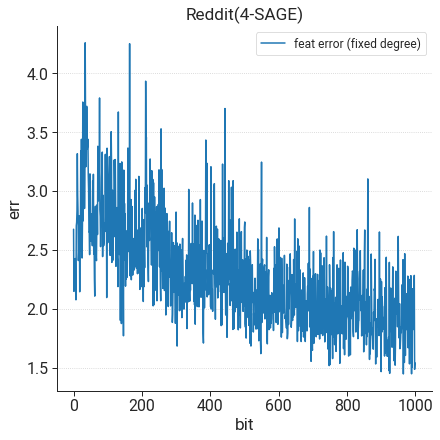

In [12]:
grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(6, 6))

# Figure 1
err = pd.read_csv('results/test.csv')

# ------------------------------------ acc -----------------------------------------------
ax1.plot(np.arange(len(err['err'])), err['err'], label='feat error (fixed degree)', linewidth=1.5, color=cmp[0])

ax1.set_xlabel(f"bit")
ax1.set_ylabel(f"err")
# ax1.set_ylim(60, 95)
# ax1.set_xlim(0, 100)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(4-SAGE)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/1.pdf", bbox_inches="tight")
    


Bit - feat error

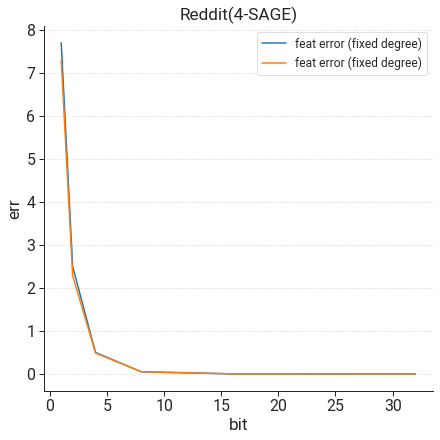

In [14]:
grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(6, 6))

# Figure 1
err = pd.read_csv('results/test.csv')

x1 = [1, 2, 4, 8, 16, 32]
err1 = [7.698, 2.499, 0.5, 0.049, 0.00157, 0]
err2 = [7.289, 2.284, 0.486, 0.0523, 0.0015, 0]

# ------------------------------------ acc -----------------------------------------------
ax1.plot(x1, err1, label='feat error (fixed degree)', linewidth=1.5, color=cmp[0])
ax1.plot(x1, err2, label='feat error (fixed degree)', linewidth=1.5, color=cmp[1])

ax1.set_xlabel(f"bit")
ax1.set_ylabel(f"err")
# ax1.set_ylim(60, 95)
# ax1.set_xlim(0, 100)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(4-SAGE)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/1.pdf", bbox_inches="tight")
    


Degree - feat error

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


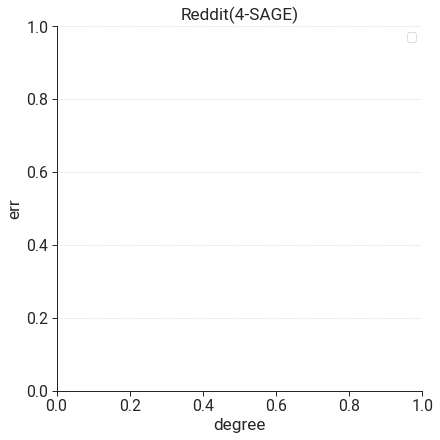

In [2]:
grid_params=dict(width_ratios=[1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(6, 6))

# Figure 1
df_deg = pd.read_csv('results/deg_1.csv')
# df_err = pd.read_csv('results/test.csv')
# df_deg['err'] = df_err['err']
# df_deg.sort_values(by=['deg'], inplace=True)

x1 = df_deg['deg']
# ------------------------------------ acc -----------------------------------------------
# ax1.plot(x1, df_deg['err'], label='feat error (1 bit)', linewidth=1.5, color=cmp[0])

ax1.set_xlabel(f"degree")
ax1.set_ylabel(f"err")
# ax1.set_ylim(60, 95)
# ax1.set_xlim(0, 100)
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
ax1.set_title('Reddit(4-SAGE)')
sns.despine()


save = False
if save:
    fig.savefig(f"{SAVEPATH}/1.pdf", bbox_inches="tight")
    


In [15]:
# import torch


# torch.tensor(list(df_deg.loc[df_deg['deg'] == 3].index))
# torch.tensor(np.array(df_deg.loc[df_deg['deg'] == 3]['index'])).shape
# df_deg['feat'] = torch.ones((10889, 128)).numpy().tolist()
# raw = np.vstack(df_deg['feat'].values).astype(float)
# torch.tensor(raw).float()
list(df_deg.index)[-1]

10888

In [8]:
import torch

a = torch.zeros((10, 4))
a[[1,2,3]] = torch.ones((3,4))
a


tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])